# Stimulated emission protocol without BD followed by repeated π (n+1 and n+1) 

In [1]:
from pylab import*
import matplotlib.pyplot as plt
import seaborn as sns
from h5py import File
import pandas as pd
from slab.dsfit import*
import json
import numpy as np
from datetime import datetime
import scipy as sc
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
# from qutip import *
from h5py import File
import os
from slab.dataanalysis import get_next_filename

C:\ProgramData\Miniconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Fit functions

In [2]:
def coherent_state(n, alpha):
    return np.exp(-abs(alpha)**2)*abs(alpha)**(2*n)/scipy.special.factorial(n)

def line(x, m, b):
    return m*x+b

def proportional(x, m):
    return m * x

def gfromchi(chi,alpha,delta):
    return np.sqrt(chi*delta*(delta+alpha)/alpha)

def gaussfuncsum(p, x):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0
    for ii in range(N):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    return y

def gaussfuncsum_with_baseline(x, *args):
    """p[0]+p[1]/(1+(x-p[2])**2/p[3]**2)"""
    y = 0 
    p = args
#     print(len(p))
    for ii in range(7):
        y = y + p[3*ii+1]*exp(-(x-(p[3*ii+2]))**2/2/p[3*ii+3]**2)
    y += p[0]
    return y
def fitgausssum(xdata, ydata, fitparams=None, domain=None, showfit=False,
                showstartfit=False, label="", debug=False):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata, ydata, domain)
    else:
        fitdatax = xdata
        fitdatay = ydata
    
    if fitparams is None:
        fitparams = 0*ones(3*N+1)
        fitparams[0] = (fitdatay[0] + fitdatay[-1])/2.
        fitparams[1] = max(fitdatay) - min(fitdatay)
        fitparams[2] = fitdatax[np.argmax(fitdatay)]
        fitparams[3] = (max(fitdatax) - min(fitdatax))/10.
    
    if debug==True: 
        print(fitparams)
        
    p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum, fitparams, domain=None, showfit=showfit, 
                    showstartfit=showstartfit, label=label)
    p1[3]=abs(p1[3])
    
    return p1

def fitgausssum_with_baseline(xdata, ydata, fitparams=None):
    """fit lorentzian:
        returns [offset,amplitude,center,hwhm]"""
    fitdatax = xdata
    fitdatay = ydata
#     if fitparams is None:
#         fitparams = 0*ones(3*N+1)
#         fitparams[0] = (fitdatay[0]+fitdatay[-1])/2.
#         fitparams[1] = max(fitdatay)-min(fitdatay)
#         fitparams[2] = fitdatax[np.argmax(fitdatay)]
#         fitparams[3] = (max(fitdatax)-min(fitdatax))/10.
    
#     p1 = fitgeneral(fitdatax, fitdatay, gaussfuncsum_with_baseline, fitparams, domain=None, showfit=showfit,
#                     showstartfit=showstartfit, label=label)
#     bounds=(0, [3., 1., 0.5])
        
    popt, pcov = curve_fit(gaussfuncsum_with_baseline, fitdatax, fitdatay, p0=fitparams, bounds=(0, np.inf))

    return popt, pcov

def fitamp(p1):
    fitamparray = []
    fitfreqarray = []
    n_peaks = int((len(p1)-1)/3)
    for i in range(n_peaks):
        fitamparray.append(p1[3*i+1])
        fitfreqarray.append(p1[3*i+2])
    return fitamparray , fitfreqarray

def fitcoherentstate(peak_val):
    xdata = np.arange(len(peak_val))
    ydata = peak_val
    popt, pcov = curve_fit(coherent_state, xdata, ydata)
    return popt[0], np.sqrt(pcov[0][0])

def expfunc2(x, p):
    """p[0]+p[1]*exp(-(x-p[2])/p[3])"""
    return p[0]*np.exp**(-(x-p[1])/p[2])

def fitexp2(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fit exponential decay (p[0]*exp(-(x-p[1])/p[2]))"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        fitparams=[0.,0.,0.,0.]
        fitparams[0]=fitdatay[0]-fitdatay[-1]
        fitparams[1]=fitdatax[0]
        fitparams[2]=(fitdatax[-1]-fitdatax[0])/5.
    #print fitparams
    p1 = fitgeneral(fitdatax, fitdatay, expfunc2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1   

def expfunc_test(x, a, b, c):
    return b*np.exp(-(x-a)/c)

def expfunc_baseline(x, a, b, c):
    return a*np.exp(-x/b) + c

def doublegauss(bins, *p):
    a1, sigma1, mu1 = p[0], p[1], p[2]
    a2, sigma2, mu2 = p[3], p[4], p[5]

    y1 = a1*((1 / (np.sqrt(2 * np.pi) * sigma1)) *
     np.exp(-0.5 * (1 / sigma1 * (bins - mu1))**2))
    y2 = a2*((1 / (np.sqrt(2 * np.pi) * sigma2)) *
     np.exp(-0.5 * (1 / sigma2 * (bins - mu2))**2))
    y = y1+y2
    
    return y
def gaussian2d(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)


def hist(filename=None, data=None, plot=True, ran=1.0):
    
    if data == None:
        with File(filename,'r') as a:
            ig = array(a['ig'])
            qg = array(a['qg'])
            ie = array(a['ie'])
            qe = array(a['qe'])
            a.close()
    else:
        ig = data[0]
        qg = data[1]
        ie = data[2]
        qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -arctan((ye-yg)/(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*cos(theta) - qg*sin(theta)
    qg_new = ig*sin(theta) + qg*cos(theta) 
    ie_new = ie*cos(theta) - qe*sin(theta)
    qe_new = ie*sin(theta) + qe*cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)

    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='upper right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binsg[:-1], ydata=ng, p0=p0)
    #     mu_g = popt[2]
    #     axs[2].plot(binsg, doublegauss(binsg, *popt), 'k--', linewidth=2 )
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
    #     popt, pcov = curve_fit(doublegauss, xdata=binse[:-1], ydata=ne, p0=p0)
    #     mu_e = popt[5]
    #     axs[2].plot(binse, doublegauss(binse, *popt), 'k--', linewidth=2 )
    #     axs[2].text(0.5*(mu_g + mu_e), 0.3*np.max(ne), "$\mu_{g}$ = %.4f \n $\mu_{e}$ = %.4f"%(mu_g, mu_e), fontsize=16)

        axs[2].set_xlabel('I(a.u.)')        
        fig.show()
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    fid = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum()))).max()

    return fid, theta

def rot_data(i, q, hist_filename=None):
    
    fid, theta = hist(hist_filename, ran=0.1)
    print(fid, theta)
    """Rotate the IQ data"""
    i_new = i*cos(theta) - q*sin(theta)
    q_new = i*sin(theta) + q*cos(theta) 
    
    return (i_new, q_new)


def ramsfit(tR, n0, phi0, a):
    T2 = 120e-6
    dephase = 1/T2
    detune = 2*np.pi*1e6 
    chi = 2*np.pi*380e3
    kappa = 2*np.pi*(8.0517e9)/8800
    tau = []
    z = []
    res = []
    for i,t in enumerate(tR):
        tau.append((1-np.exp(-complex(kappa*tR[i], 2*chi*tR[i])))/complex(kappa, 2*chi))
        z.append(np.exp(complex(-dephase*tR[i] , phi0 - detune*tR[i] - 2*n0*chi*tau[i])))
        res.append(a*0.5*(1-np.imag(z[i])))
    return np.array(res)

def cav_response_new(p, x):
    """(p[0]/p[1])/(-1/2*p[0]/p[1] - 1j*(x-p[0])"""
    ### p[0]=center freq, p[1]=kappa
    temp = (p[1])/(p[1] - 1j*(x-p[0]))
    return temp/max(abs(temp))

def IF_window(p,x):
    ### p[0] = center freq, p[1] = window width
    temp = zeros(len(x)) + 1j*zeros(len(x))
    for ii in range(len(x)):
        if x[ii]>(p[0]-p[1]) and x[ii]<(p[0]+p[1]):
            temp[ii] = 1/sqrt(2)*(1+1j)
        else:
            pass
    return temp/max(abs(temp))

def erf_t(A, sig, tc, tb, t):
    #A-Amplitude, sig-Gaussian Filter Width, tc-Core Pulse length, tb - zero-amplitude buffer length
    return (A/2)*(sc.special.erf((t-tb)/(sqrt(2)*sig))-sc.special.erf((t-tc-tb)/(sqrt(2)*sig)))

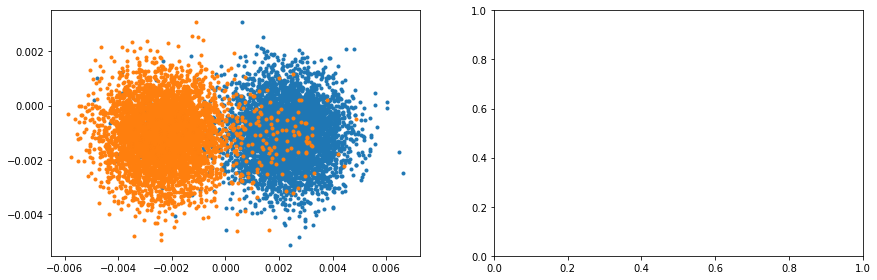

In [36]:
expt_name = 'histogram_disc_clear'
filelist = [0]
import seaborn as sns

for ii, i in enumerate(filelist):
    filename = "..\\data\\thesis\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:
        
        I = array(a['I'])
        Q = array(a['Q'])
        res = array(a['res'])
        avgs = array(a['avgs'])
        seq0 = array(a['seq0'])
        a.close()
        
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

axs[0].plot(I[np.array(seq0) == 0], Q[np.array(seq0) == 0] , '.', label='g')
axs[0].plot(I[np.array(seq0) == 1], Q[np.array(seq0) == 1], '.', label='e')

In [68]:
# """Pass the histogram blobs"""
# expt_name = 'histogram_clear'
# filelist = [0]

# for ii, i in enumerate(filelist):
#     filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

class readout_ge_disc:
    def __init__(self):
        pass

    def readout_fidelity(self, histogram_file=None, plot=False):
        with File(histogram_file,'r') as f:
            
#             self.ig = np.array(f['ig'])
#             self.qg = np.array(f['qg'])
#             self.ie = np.array(f['ie'])
#             self.qe = np.array(f['qe'])
            I = np.array(f['I'])
            Q = np.array(f['Q'])
            res = np.array(f['res'])
            avgs = np.array(f['avgs'])
            seq0 = np.array(f['seq0'])

            self.ig, self.qg  = I[np.array(seq0) == 0], Q[np.array(seq0) == 0]
            self.ie, self.qe  = I[np.array(seq0) == 1], Q[np.array(seq0) == 1]
        
        if plot:
            fig, axs = plt.subplots(nrows=1, ncols=1)
            axs.plot(self.ig, self.qg, '.', label='g')
            axs.plot(self.ie, self.qe, '.', label='e')
            axs.legend(loc='best')
            plt.show()
            
        xg, yg = np.median(self.ig), np.median(self.qg)
        xe, ye = np.median(self.ie), np.median(self.qe)

        gg_radius = np.sqrt((self.ig-xg)**2 + (self.qg-yg)**2)
        eg_radius = np.sqrt((self.ig-xe)**2 + (self.qg-ye)**2)

        ge_radius = np.sqrt((self.ie-xg)**2 + (self.qe-yg)**2)
        ee_radius = np.sqrt((self.ie-xe)**2 + (self.qe-ye)**2)

        num_sigmas = 2
        num_bins = int(np.sqrt(len(gg_radius)))+1
        bins = np.linspace(0, max(gg_radius), num_bins)

        counts, bin_edges = np.histogram(gg_radius, bins)
        counts_g = counts/sum(counts)
        bins_g = bin_edges[:-1]

        counts, bin_edges = np.histogram(ee_radius, bins)
        counts_e = counts/sum(counts)
        bins_e = bin_edges[:-1]

        self.centers = [[xg, yg],[xe, ye]]
        self.counts = [counts_g, counts_e]
        self.bins = bins[:-1]

        g_I = self.ig
        g_Q = self.qg
        e_I = self.ie
        e_Q = self.qe

        g_qubit_state_prob_counts = []
        e_qubit_state_prob_counts = []
        for jj in range(len(g_I)):
            g_probs_counts = []
            e_probs_counts = []
            for ii in range(len(self.centers)):
                dist = np.sqrt((g_I[jj]-self.centers[ii][0])**2 + (g_Q[jj]-self.centers[ii][1])**2)
                dist_index = np.argmin(abs(self.bins-dist))
                g_probs_counts.append(self.counts[ii][dist_index])

                dist = np.sqrt((e_I[jj]-self.centers[ii][0])**2 + (e_Q[jj]-self.centers[ii][1])**2)
                dist_index = np.argmin(abs(self.bins-dist))
                e_probs_counts.append(self.counts[ii][dist_index])

            g_probs_counts = g_probs_counts/sum(g_probs_counts)
            g_qubit_state_prob_counts.append(g_probs_counts)

            e_probs_counts = e_probs_counts/sum(e_probs_counts)
            e_qubit_state_prob_counts.append(e_probs_counts)

        g_state_prob_list = asarray(g_qubit_state_prob_counts).T[0]
        e_state_prob_list = asarray(e_qubit_state_prob_counts).T[1]

        g_counter = 0
        e_counter = 0
        readout_thresh = 1/2
        for ii in range(len(g_state_prob_list)):
            if g_state_prob_list[ii] <= readout_thresh:
                g_counter = g_counter + 1
            if e_state_prob_list[ii] <= readout_thresh:
                e_counter = e_counter + 1

        Pge = 0.016*(1-np.exp(-3.2/120))
        Peg = 1-np.exp(-3.2/120)

        g_inf = g_counter/len(g_state_prob_list) - Pge
        e_inf = e_counter/len(e_state_prob_list) - Peg

        g_inf_err = np.sqrt(g_counter)/len(g_state_prob_list)
        e_inf_err = np.sqrt(e_counter)/len(e_state_prob_list)


        infidelities = [g_inf, e_inf, g_inf_err, e_inf_err]

        return infidelities

    def hist_disc(self, I, Q):
        qubit_state_prob_counts = []
        for i, q in zip(I, Q):
            probs_counts = []
            for ii in range(len(self.centers)):
                dist = np.sqrt((i-self.centers[ii][0])**2 + (q-self.centers[ii][1])**2)
                dist_index = np.argmin(abs(self.bins-dist))
                probs_counts.append(self.counts[ii][dist_index])
            probs_counts = probs_counts/sum(probs_counts)
            qubit_state_prob_counts.append(probs_counts)

        meas_sequence = []
        g_state_prob_list = asarray(qubit_state_prob_counts).T[0]
        e_state_prob_list = asarray(qubit_state_prob_counts).T[1]
        probs_counts = []
        for ii in range (len(g_state_prob_list)):
            if g_state_prob_list[ii]>0.5:
                meas_sequence.append(0)
            elif e_state_prob_list[ii]>0.5:
                meas_sequence.append(1)
            else:
                if ii == 0:
                    meas_sequence.append(0)
                else:
                    meas_sequence.append(meas_sequence[ii-1])
                    
        return meas_sequence

In [94]:
0.016*(1-np.exp(-3.2/120))

0.00042102801034968

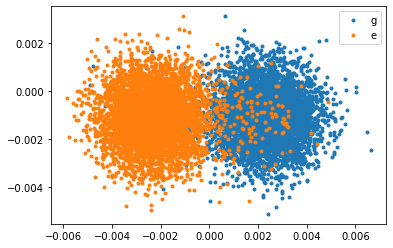

[0.031778971989650316, 0.009485749353145001, 0.002537715508089904, 0.0026758176320519304]


In [69]:
filename = '../data/thesis/00000_histogram_disc_clear.h5'
ob = readout_ge_disc()

infid = ob.readout_fidelity(histogram_file=filename, plot=True)

print(infid)

In [92]:
ob.hist_disc(I =[-0.0003], Q= [0.0])

[1]

# HMM Model

In [98]:
class hmm_analysis_stimem(readout_ge_disc):

    def __init__(self, qubit_params = None, cavity_params = None, readout_params = None):
        
        self.qubit_params = qubit_params
        self.cavity_params = cavity_params
        self.readout_params = readout_params

        """All the timescales are in μs"""
        self.qubit_t1 = qubit_params['t1']
        self.qubit_t2 = qubit_params['t2']
        self.qubit_nth = qubit_params['nth']
        
        self.cavity_t1 = cavity_params['t1']
        self.cavity_nth = cavity_params['nth']
        
        self.readout_len = readout_params['length']        
        self.trigger_period = readout_params['trigger']
        self.pi_length = readout_params['pi_pulse']
        self.g_inf = readout_params['g_inf']        
        self.e_inf = readout_params['e_inf']      
        
    ##----------------------------------------------------------------##
    def forward(self, meas_seq, T, E):
        num_meas = len(meas_seq)
        N = T.shape[0]
        alpha = zeros((num_meas, N))
        pi = [0.25, 0.25, 0.25, 0.25]
        alpha[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
        return alpha

    def backward(self, meas_seq, T, E):
        N = T.shape[0]
        num_meas = len(meas_seq)
        beta = zeros((N,num_meas))
        beta[:,-1:] = 1
        for t in reversed(range(num_meas-1)):
            for n in range(N):
                beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
        return beta

    def likelihood(self, meas_seq, T, E):
        # returns log P(Y  \mid  model)
        # using the forward part of the forward-backward algorithm
        return  self.forward(meas_seq, T, E)[-1].sum()

    def gamma(self, meas_seq, T, E):
        alpha = self.forward(meas_seq, T, E)
        beta  = self.backward(meas_seq, T, E)
        obs_prob = self.likelihood(meas_seq, T, E)
        return (multiply(alpha, beta.T) / obs_prob)

    def viterbi(self, meas_seq, T, E):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        num_meas = len(meas_seq)
        N = T.shape[0]
        delta = zeros((num_meas, N))
        psi = zeros((num_meas, N))
        pi = [0.25,0.25,0.25,0.25]
        delta[0] = pi*E[:,meas_seq[0]]
        for t in range(1, num_meas):
            for j in range(N):
                delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
                psi[t,j] = argmax(delta[t-1]*T[:,j])

        # backtrack
        states = zeros(num_meas, dtype=int32)
        states[num_meas-1] = argmax(delta[num_meas-1])
        for t in range(num_meas-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        return states
    ##----------------------------------------------------------------##
    def alpha_awg_cal(self, cav_amp=0.4, cav_len=250):
        # takes input array of amps and length and converts them to output array of alphas,
        # using a calibration h5 file defined in the experiment config
        # pull calibration data from file, handling properly in case of multimode cavity
        cal_path = 'C:\_Lib\python\slab\experiments\qm_opx_mm\drive_calibration'

        fn_file = cal_path + '\\00000_2021_12_16_cavity_square_mode_2.h5'

        with File(fn_file, 'r') as f:
            omegas = np.array(f['omegas'])
            amps = np.array(f['amps'])

        # assume zero frequency at zero amplitude, used for interpolation function
        omegas = np.append(omegas, 0.0)
        amps = np.append(amps, 0.0)

        o_s = omegas
        a_s = amps

        # interpolate data, transfer_fn is a function that for each amp returns the corresponding omega
        transfer_fn = scipy.interpolate.interp1d(a_s, o_s)

        omega_desired = transfer_fn(cav_amp)
        alpha = omega_desired * cav_len

        """Returns alpha in the cavity"""
        return alpha
        
    ##----------------------------------------------------------------##
    def openfile(self, filename):
        
        return File(filename,'r')

    def stateprep(self, data_filename=None, at_end=True, t2_err=0.0, fstate_in=0, hist_file=None):
        
        """Readout fidelities from an independent measurement"""
        g_infidelity, e_infidelity = self.g_inf, self.e_inf
        
        self.a = self.openfile(data_filename)

        I = pd.DataFrame(self.a['I'])[:]
        Q = pd.DataFrame(self.a['Q'])[:]
        
        cav_amp = np.array(self.a['amp']) 
        cav_len = np.array(self.a['time']) 
        
        npi_m = int(np.array(self.a['pi_m']))
        npi_n = int(np.array(self.a['pi_n']))
        alpha = np.array(self.a['alpha'])

        self.a.close()
        
        print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
        print('Coherent drive: amp = {}, length = {} ns'.format(cav_amp, cav_len))

        
        p_n_counts = []
        
        g_infidelity, e_infidelity, g_inf_err, e_inf_err = self.readout_fidelity(histogram_file=hist_file)
        
        """T and E matrices for the second half of the experiment"""
        cavity_t1 = self.cavity_t1/(fstate_in+1)
        Pnm =  (1-np.exp(-self.trigger_period/cavity_t1)) + self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1))

        Pmn = self.cavity_nth * (1-np.exp(-self.trigger_period/cavity_t1)) + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\

        Pge = self.qubit_nth * (1-np.exp(-self.trigger_period/self.qubit_t1)) +\
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)
        Peg = (1-np.exp(-self.trigger_period/self.qubit_t1)) + \
            (1-np.exp(-self.pi_length/self.qubit_t2) - t2_err)

        T_n = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
             [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
             [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
             [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

        E_n = 0.5*asarray([[1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity],
            [1-g_infidelity, g_infidelity],
            [e_infidelity, 1- e_infidelity]])
        
        for jj in range(len(I)):
            """After the coherent drive, probabilities at the begining of n π pulses"""    
            meas_seq = self.hist_disc(I.iloc[jj], Q.iloc[jj])
            gamma_matrix = self.gamma(meas_seq, T_n, E_n)
            P0_first = gamma_matrix[0,0] + gamma_matrix[0,1]
            P1_first = gamma_matrix[0,2] + gamma_matrix[0,3]   
            p_n_counts.append(P1_first/P0_first)
        
        return alpha, cav_amp, p_n_counts

## Debug/Estimating number of pi pulses

In [ ]:
expt_name = 'stim_em_nobd_nodisc'
filelist = [0]
# 4 => n=0
# 7 => n=1

qubit_freq = 4.746910599438208
two_chi = -1.13e6
for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        bit1 = np.array(a['bit1'])[:]
        bit2 = np.array(a['bit2'])[:]
        bit3 = pd.DataFrame(a['bit3'])[:]
        
        p_cav = np.array(a['p_cav'])/100
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        npi_m = int(np.array(a['pi_m']))
        npi_n = int(np.array(a['pi_n']))

        a.close()

print(np.shape(p_cav))
print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
df = bit3
print(np.shape(df))

nx, ny = np.shape(df)

pd.set_option('display.max_rows', None)
l = []
for i in range(ny):
    l.append('π%i'%i)
df.columns = l

df['n'] = bit1+2*bit2

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols].sort_values(by=['n'])
# print(df)

In [ ]:
df.style.set_table_styles( [{'selector': 'tr:hover',   'props': [('background-color', 'yellow')]}] )

In [ ]:
(unique, counts) = np.unique(df['n'], return_counts=True)


print(unique, counts)
df.iloc[4000][:]

In [ ]:
##----------------------------------------------------------------##
def forward( meas_seq, T, E):
    num_meas = len(meas_seq)
    N = T.shape[0]
    alpha = zeros((num_meas, N))
    pi = [0.25, 0.25, 0.25, 0.25]
    alpha[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
    return alpha

def backward( meas_seq, T, E):
    N = T.shape[0]
    num_meas = len(meas_seq)
    beta = zeros((N,num_meas))
    beta[:,-1:] = 1
    for t in reversed(range(num_meas-1)):
        for n in range(N):
            beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
    return beta

def likelihood( meas_seq, T, E):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return  forward(meas_seq, T, E)[-1].sum()

def gamma( meas_seq, T, E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha, beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
    # returns the most likely state sequence given observed sequence x
    # using the Viterbi algorithm
    num_meas = len(meas_seq)
    N = T.shape[0]
    delta = zeros((num_meas, N))
    psi = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25]
    delta[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        for j in range(N):
            delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
            psi[t,j] = argmax(delta[t-1]*T[:,j])

    # backtrack
    states = zeros(num_meas, dtype=int32)
    states[num_meas-1] = argmax(delta[num_meas-1])
    for t in range(num_meas-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


qubit_params = {'t1':100, 't2':130, 'nth':5e-2}
cavity_params = {'t1':5e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':3}

qubit_t1 = qubit_params['t1']
qubit_t2 = qubit_params['t2']
qubit_nth = qubit_params['nth']
cavity_t1 = cavity_params['t1']
cavity_nth = cavity_params['nth']

readout_len = readout_params['length']        
trigger_period = readout_params['trigger']
pi_length = readout_params['pi_pulse']

"""Readout fidelities from an independent measurement"""
g_infidelity, e_infidelity = 0.0194, 0.06647

fstate_in = 0

if fstate_in == 0:
    cavity_t1 = cavity_t1/1
    Pnm =  cavity_nth * (1-np.exp(-trigger_period/cavity_t1))
else:
    cavity_t1 = cavity_t1/fstate_in
    Pnm =  (1-np.exp(-trigger_period/cavity_t1)) + cavity_nth * (1-np.exp(-strigger_period/cavity_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_nth * (1-np.exp(-trigger_period/qubit_t1)) +\
    (1-np.exp(-pi_length/qubit_t2))
Peg = (1-np.exp(-trigger_period/qubit_t1)) + \
    (1-np.exp(-pi_length/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

meas_seq = df.iloc[4000][1:1+npi_m]
P0_last = []
P1_last = []
print(len(meas_seq))

p_m_temp = []

for kk in range (len(meas_seq)):
    temp_meas_sequence = meas_seq[0:kk+1]
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_last.append(gamma_matrix[-1,0] + gamma_matrix[-1,1])
    P1_last.append(gamma_matrix[-1,2] + gamma_matrix[-1,3])

In [ ]:
P0_last[-1]

In [ ]:
"""### Threshold analysis to estimate the number of pi pulses to be included for < detector based errors"""
plt.figure(dpi=300)

n = np.arange(npi_m)
t1_err = (1-np.exp(-n*trigger_period/cavity_t1))

plt.semilogy(np.array(P0_last), '.', label='!|n+1>')
plt.semilogy(np.array(P1_last), '*', label='|n+1>')
plt.semilogy(t1_err, 'o', label='T1 decay of |n>')
# plt.semilogy(1-t1_err, 'D', label='1-T1')

plt.xticks([0, 5, 10])
plt.ylabel('P(n+1|n)')
plt.xlabel('Number of π pulses included')
plt.legend(loc='best')
plt.show()

In [ ]:
meas_seq = df.iloc[4000][:]
P0_first = []
P1_first =  []
for kk in range (len(meas_seq)):
    temp_meas_sequence = meas_seq[1+npi_m:]
    gamma_matrix = gamma(temp_meas_sequence, T, E)
    P0_first.append(gamma_matrix[0,0] + gamma_matrix[0,1])
    P1_first.append(gamma_matrix[0,2] + gamma_matrix[0,3])

In [ ]:
plt.plot(np.arange(npi_n), meas_seq[1+npi_m:], '.')
plt.show()

In [ ]:
"""### Threshold analysis to estimate the number of pi pulses to be included for < detector based errors"""
plt.figure(dpi=300)

n = np.arange(npi_n)
t1_err = (1-np.exp(-n*trigger_period/cavity_t1))

plt.semilogy(np.array(P0_first), '.', label='!|n+1>')
plt.semilogy(np.array(P1_first), '*', label='|n+1>')
plt.semilogy(t1_err, 'o', label='T1 decay of |n>')
# plt.semilogy(1-t1_err, 'D', label='1-T1')

plt.xticks([0, 5, 10, 15, 20, 25, 30])
plt.ylabel('P(n+1|n)')
plt.xlabel('Number of π pulses included')
plt.legend(loc='best')
plt.show()

## Estimating the cavity state decay after repeated pi pulses

In [ ]:
expt_name = 'stim_em_bd_rp_debug'
filelist = [36]
# 0 => n=1 with pi's at n+1
# 1 => n=1 with pi's at n
# 2 => n=1 with pi's at n+1 but an active reset before last BD

# 32 - n=1, no first BD, 10 rep pi pulses and then last BD
# 33 - n=1, no first BD, 6 rep pi pulses and then last BD
# 34 - n=2, first BD, 10 pi's and BD
# 35 - n=3, first BD, 10 pi's and BD
# 36 - n=1, first BD, 10 pi's and BD

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        num1 = np.array(a['num1'])[:]
        num2 = np.array(a['num2'])[:]
        bit3 = pd.DataFrame(a['bit3'])[:]
        
        p_cav = np.array(a['p_cav'])/100
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        npi_m = int(np.array(a['pi_m']))
        npi_n = int(np.array(a['pi_n']))

        a.close()
        
print(np.shape(p_cav))
print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
df = bit3
print(np.shape(df))

nx, ny = np.shape(df)

pd.set_option('display.max_rows', None)
l = []
for i in range(ny):
    l.append('π%i'%i)
df.columns = l

df['m'] = num1
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols].sort_values(by=['m'])
df['n'] = num2

In [ ]:
(unique, counts) = np.unique(df['n'], return_counts=True)

print(unique, counts)

In [ ]:
(unique, counts) = np.unique(df['m'], return_counts=True)

print(unique, counts)

In [ ]:
count_m = df['m'][df['m']==1].count() #Number of times n=1 measured after preparing n=1

count_n = df['m'][(df['m']==1) & (df['n']==1)].count() #Number of times n=1 measured pre and post repeated pi pulses

print(count_m, count_n)

In [ ]:
count_p = df['n'][(df['n']==1) & (df['π9']==1)].count()

print(count_p)

In [ ]:
df[counts[2]:counts[2]+10]

In [ ]:
plt.plot(df.iloc[counts[0]+1][1:-1], '.--')

In [ ]:
count_n/count_m

In [ ]:
12068/15000, 7200/12068

In [ ]:
"""Estimates from HMM"""

##----------------------------------------------------------------##
def forward( meas_seq, T, E):
    num_meas = len(meas_seq)
    N = T.shape[0]
    alpha = zeros((num_meas, N))
    pi = [0.25, 0.25, 0.25, 0.25]
    alpha[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        alpha[t] = alpha[t-1].dot(T) * E[:, meas_seq[t]]
    return alpha

def backward( meas_seq, T, E):
    N = T.shape[0]
    num_meas = len(meas_seq)
    beta = zeros((N,num_meas))
    beta[:,-1:] = 1
    for t in reversed(range(num_meas-1)):
        for n in range(N):
            beta[n,t] = sum(beta[:,t+1] * T[n,:] * E[:, meas_seq[t+1]])
    return beta

def likelihood( meas_seq, T, E):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return  forward(meas_seq, T, E)[-1].sum()

def gamma( meas_seq, T, E):
    alpha = forward(meas_seq, T, E)
    beta  = backward(meas_seq, T, E)
    obs_prob = likelihood(meas_seq, T, E)
    return (multiply(alpha, beta.T) / obs_prob)

def viterbi(meas_seq, T, E):
    # returns the most likely state sequence given observed sequence x
    # using the Viterbi algorithm
    num_meas = len(meas_seq)
    N = T.shape[0]
    delta = zeros((num_meas, N))
    psi = zeros((num_meas, N))
    pi = [0.25,0.25,0.25,0.25]
    delta[0] = pi*E[:,meas_seq[0]]
    for t in range(1, num_meas):
        for j in range(N):
            delta[t,j] = max(delta[t-1]*T[:,j]) * E[j, meas_seq[t]]
            psi[t,j] = argmax(delta[t-1]*T[:,j])

    # backtrack
    states = zeros(num_meas, dtype=int32)
    states[num_meas-1] = argmax(delta[num_meas-1])
    for t in range(num_meas-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states


qubit_params = {'t1':100, 't2':100, 'nth':5e-2}
cavity_params = {'t1':6.8e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':0.5}

qubit_t1 = qubit_params['t1']
qubit_t2 = qubit_params['t2']
qubit_nth = qubit_params['nth']
cavity_t1 = cavity_params['t1']
cavity_nth = cavity_params['nth']

readout_len = readout_params['length']        
trigger_period = readout_params['trigger']
pi_length = readout_params['pi_pulse']

"""Readout fidelities from an independent measurement"""
g_infidelity, e_infidelity = 0.0194, 0.06647

fstate_in = 1

if fstate_in == 0:
    cavity_t1 = cavity_t1/1
    Pnm =  cavity_nth * (1-np.exp(-trigger_period/cavity_t1))
else:
    cavity_t1 = cavity_t1/fstate_in
    Pnm =  (1-np.exp(-trigger_period/cavity_t1)) + cavity_nth * (1-np.exp(-trigger_period/cavity_t1))

Pmn = 0 + 0 #assuming that the population at (n+1) is negligible and (n-1) we will estimate\
Pge = qubit_nth * (1-np.exp(-trigger_period/qubit_t1)) +\
    (1-np.exp(-pi_length/qubit_t2))
Peg = (1-np.exp(-trigger_period/qubit_t1)) + \
    (1-np.exp(-pi_length/qubit_t2))

T = asarray([[(1-Pmn)*(1-Pge), (1-Pmn)*Pge, Pmn*Pge, Pmn*(1-Pge)],
     [(1-Pmn)*Peg, (1-Pmn)*(1-Peg), Pmn*(1-Peg), Pmn*Peg],
     [Pnm*(1-Pge), Pnm*Pge, (1-Pnm)*Pge, (1-Pnm)*(1-Pge)],
     [Pnm*Peg, Pnm*(1-Peg), (1-Pnm)*(1-Peg), (1-Pnm)*Peg]])

E = 0.5*asarray([[1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity],
    [1-g_infidelity, g_infidelity],
    [e_infidelity, 1- e_infidelity]])

p_m_counts = []

for i in range(counts[1]):

    meas_seq = df.iloc[counts[0]+i][1:1+npi_m]
    P0_last = []
    P1_last = []

    gamma_matrix = gamma(meas_seq, T, E)
    P0_last=(gamma_matrix[-1,0] + gamma_matrix[-1,1])
    P1_last=(gamma_matrix[-1,2] + gamma_matrix[-1,3])
    p_m_counts.append(P1_last/P0_last)

In [ ]:
len(p_m_counts)

In [ ]:
df = pd.DataFrame(p_m_counts)

th = 1e2

count_m = df[df>th].count()
count_m

In [ ]:
df[df>th]

In [ ]:
9672/15000

## Actual analysis for |n=0>

In [ ]:
qubit_params = {'t1':100, 't2':130, 'nth':5e-2}
cavity_params = {'t1':5e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':3}
expt_name = 'stim_em_bd_rp_oct'
filelist = [22]

p_counts = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    obj = hmm_analysis(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    alpha, unique, counts, p_m_counts, p_n_counts = obj.stateprep(data_filename=filename)

In [ ]:
df = pd.DataFrame(p_m_counts[0])
print(df[df < 1e-5 ].count() /len(p_m_counts[0]))
df = pd.DataFrame(p_n_counts[0])
print(df[df < 1e-3 ].count() /len(p_n_counts[0]))

In [ ]:
plt.his

In [ ]:
plt.figure(dpi=300)
plt.plot(p_m_counts[0], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_m_counts[0]):
    if p < 1e-5:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_m_counts[0]))

In [ ]:
plt.figure(dpi=300)
plt.plot(p_n_counts[0], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(zip(p_m_counts[0], p_n_counts[0])):
    if p[0] < 1e-5 and p[1] < 1e-3:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_n_counts[0]))

## Actual analysis for |n> = 1>

In [ ]:
qubit_params = {'t1':100, 't2':100, 'nth':5e-2}
cavity_params = {'t1':5e2, 'nth':0.001}
readout_params = {'length':3.2, 'trigger':7.2, 'pi_pulse':3}
expt_name = 'stim_em_bd_rp'
filelist = [12]

#11- OCT
#12- OCT

p_m_counts = []
p_n_counts = []

for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    obj = hmm_analysis(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
    unique, counts, p_m_counts, p_n_counts = obj.stateprep(data_filename=filename)

In [ ]:
plt.figure(dpi=300)
plt.plot(p_m_counts[1], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(p_m_counts[1]):
    if p < 1e-5:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_m_counts[1]))

In [ ]:
plt.figure(dpi=300)
plt.plot(p_n_counts[1], '.', color='firebrick')
plt.ylabel(r'$\lambda_{th}$')
plt.xlabel('Iteration #')
plt.yscale('log')
plt.show()

x = []
for ii, p in enumerate(zip(p_m_counts[1], p_n_counts[1])):
    if p[0] < 1e-5 and p[1] < 1e-3:
#         print(ii)
        x.append(ii)
    
print(len(x)/len(p_n_counts[1]))

# Repeated BD

In [ ]:
expt_name = 'stim_em_bd_rep_bd_debug'
filelist = [3]
# 0 => n=1 with pi's at n+1
# 1 => n=1 with pi's at n
# 2 => n=1 with pi's at n+1 but an active reset before last BD


for ii, i in enumerate(filelist):
    filename = "..\\data\\" + str(i).zfill(5) + "_"+expt_name.lower()+".h5"

    with File(filename,'r') as a:

        num1 = np.array(a['num1'])[:]        
        cav_amp = np.array(a['amp'])
        cav_len = np.array(a['time'])
        npi_m = int(np.array(a['pi_m']))
        npi_n = int( np.array(a['pi_n']))

        a.close()

print('# of π at m= {}, at n = {}'.format(npi_m, npi_n))
df = pd.DataFrame(num1)
print(np.shape(df))

nx, ny = np.shape(df)

pd.set_option('display.max_rows', None)
l = []
for i in range(ny):
    l.append('BD%i'%i)
df.columns = l

# df['m'] = num1
# cols = df.columns.tolist()
# cols = cols[-1:] + cols[:-1]
# df = df[cols].sort_values(by=['m'])
# df['n'] = num2

In [ ]:
df.iloc[10000]

In [ ]:
(unique, counts) = np.unique(df['BD0'], return_counts=True)

print(unique, counts)

In [ ]:
(unique, counts) = np.unique(df['BD9'], return_counts=True)

print(unique, counts)

In [ ]:
count_m = df['BD0'][df['BD0']==1].count() #Number of times n=1 measured after preparing n=1

count_n = df['BD0'][(df['BD0']==1) & (df['BD9']==1)].count() #Number of times n=1 measured pre and post repeated pi pulses

print(count_m, count_n)

In [ ]:
ind = df.index[(df['BD0']==1) & (df['BD9']==1)].tolist()

In [ ]:
ind[:10]

In [ ]:
df.iloc[ind[1]]

In [ ]:
hist_counts = {}
hist_counts = {'0':[], '1':[], '2':[], '3':[]}

for ii in range(len(ind)):
    
    (unique, counts) = np.unique(df.iloc[ind[ii]], return_counts=True)
    
    for jj in range(len(unique)):
        if unique[jj]==0:
            hist_counts['0'].extend([counts[jj]])
        elif unique[jj]==1:
            hist_counts['1'].extend([counts[jj]])
        elif unique[jj]==2:
            hist_counts['2'].extend([counts[jj]])
        elif unique[jj]==3:
            hist_counts['3'].extend([counts[jj]])

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4), sharey=True)
fig.tight_layout()
for i in range(4):

    axs[i].hist(hist_counts[str(i)], alpha=0.75, label='i')
    axs[i].set_title('n={}'.format(i))
    axs[i].set_xlabel('Number of occurences')
#     plt.hist(hist_counts['1'], alpha=0.25, label='1')
#     # plt.show()

#     # plt.figure()
#     plt.hist(hist_counts['2'], alpha=0.25, label='2')
#     plt.hist(hist_counts['3'], alpha=0.25, label='3')
axs[0].set_ylabel('Number')
plt.show()

# Stim Em with repeated pi pulses at |n> = 0

## Camp = 0.0to 0.9

In [99]:
import json

filename = '..//data/stim_em_nobd_nodisc/00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 0

data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
inj_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//injected_photon//'
hist_path = '../data/thesis/00000_histogram_disc_clear.h5'

for amp in camp[:]:
    data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=hist_path, fstate_in=fock_state)
        p_n_counts.extend(p_n)        
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n0_camp_0.001_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.001_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00072342)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.001.h5
(10000, 1)
5
['00000_stim_em_n0_camp_0.002_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.002_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.002, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00144684)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.002.h5
(10000, 1)
9
['00000_stim_em_n0_camp_0.003_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.003_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.003, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00217026)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.003.h5
(10000, 1)
11
['00000_stim_em_n0_camp_0.004_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.004_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.004, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00289368)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.004.h5
(10000, 1)
4
['00000_stim_em_n0_camp_0.005_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.005_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.005, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00361709)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.005.h5
(10000, 1)
6
['00000_stim_em_n0_camp_0.006_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.006_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.006, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00434051)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.006.h5
(10000, 1)
7
['00000_stim_em_n0_camp_0.007_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.007_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.007, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00504764)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.007.h5
(10000, 1)
8
['00000_stim_em_n0_camp_0.008_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.008_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.008, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00611287)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.008.h5
(10000, 1)
7
['00000_stim_em_n0_camp_0.009_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.009_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.009, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0067126)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.009.h5
(10000, 1)
5
['00000_stim_em_n0_camp_0.01_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.01_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.01, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00752348)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.01.h5
(10000, 1)
8
['00000_stim_em_n0_camp_0.02_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.02_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.02, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.01518971)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.02.h5
(10000, 1)
10
['00000_stim_em_n0_camp_0.03_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.03_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.03, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.02281172)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.03.h5
(10000, 1)
12
['00000_stim_em_n0_camp_0.04_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.04_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.04, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0304455)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.04.h5
(10000, 1)
2
['00000_stim_em_n0_camp_0.05_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.05_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.05, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.03780074)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.05.h5
(10000, 1)
17
['00000_stim_em_n0_camp_0.06_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.06_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.06, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.04552206)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.06.h5
(10000, 1)
23
['00000_stim_em_n0_camp_0.07_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.07_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.07, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05360174)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.07.h5
(10000, 1)
13
['00000_stim_em_n0_camp_0.08_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.08_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.08, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05925771)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.08.h5
(10000, 1)
14
['00000_stim_em_n0_camp_0.09_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.09_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.09, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.06845682)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.09.h5
(10000, 1)
25
['00000_stim_em_n0_camp_0.1_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.1_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.1, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.07761038)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.1.h5
(10000, 1)
24
['00000_stim_em_n0_camp_0.2_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.2_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.2, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.14664004)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.2.h5
(10000, 1)
118
['00000_stim_em_n0_camp_0.3_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.3_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.3, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.22781655)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.3.h5
(10000, 1)
247
['00000_stim_em_n0_camp_0.4_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.4_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.4, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.29632022)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.4.h5
(10000, 1)
428
['00000_stim_em_n0_camp_0.5_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.5_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.5, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.38191889)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.5.h5
(10000, 1)
653
['00000_stim_em_n0_camp_0.6_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.6_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.6, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.47308384)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.6.h5
(10000, 1)
837
['00000_stim_em_n0_camp_0.7_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.7_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.7, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.54888121)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.7.h5
(10000, 1)
1061
['00000_stim_em_n0_camp_0.8_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.8_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.8, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.59018374)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.8.h5
(10000, 1)
1327
['00000_stim_em_n0_camp_0.9_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.9_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.9, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.73878927)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.9.h5
(10000, 1)
1555
['00000_stim_em_n0_camp_0.0_len_10.h5']
..//data/stim_em_nobd_nodisc//n0//00000_stim_em_n0_camp_0.0_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.)]
..//data/stim_em_nobd_nodisc//n0//injected_photon//n0_camp_0.0.h5
(10000, 1)
11


In [97]:
df = pd.DataFrame({'p_n': p_n_counts})

print(np.shape(df))
th1 = 1e2
th2 = 1e5
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)


(10000, 1)
4


In [ ]:
readout_params

In [ ]:
th1 = 1e2
th2 = 1e4

df = pd.DataFrame({'p_m': p_m_counts, 'p_n': p_n_counts})

count_m = df['p_m'][df['p_m']>th1].count()
print(count_m)
count_n = df['p_n'][df['p_n']>th2].count()
print(count_n)

count_p = df['p_n'][(df['p_m']>th1) & (df['p_n']>th2)].count()

print(count_p, count_p/count_m)

## Photon counter fit

In [100]:
data_path =  "../data/stim_em_nobd_nodisc/n0/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 6)]= detect
    detected_th_err[np.round(alpha, 6)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n0_camp_0.0.h5
0.0
Total number of events collected: 10000, 11 events crossed \lambda 
n0_camp_0.001.h5
0.000723
Total number of events collected: 10000, 5 events crossed \lambda 
n0_camp_0.002.h5
0.001447
Total number of events collected: 10000, 9 events crossed \lambda 
n0_camp_0.003.h5
0.00217
Total number of events collected: 10000, 11 events crossed \lambda 
n0_camp_0.004.h5
0.002894
Total number of events collected: 10000, 4 events crossed \lambda 
n0_camp_0.005.h5
0.003617
Total number of events collected: 10000, 6 events crossed \lambda 
n0_camp_0.006.h5
0.004341
Total number of events collected: 10000, 7 events crossed \lambda 
n0_camp_0.007.h5
0.005048
Total number of events collected: 10000, 8 events crossed \lambda 
n0_camp_0.008.h5
0.006113
Total number of events collected: 10000, 7 events crossed \lambda 
n0_camp_0.009.h5
0.006713
Total number of events collected: 10000, 5 events crossed \lambda 
n0_camp_0.01.h5
0.007523
Total number of events collected: 10000, 8 events c

In [ ]:
len(n_exp), np.shape(y)

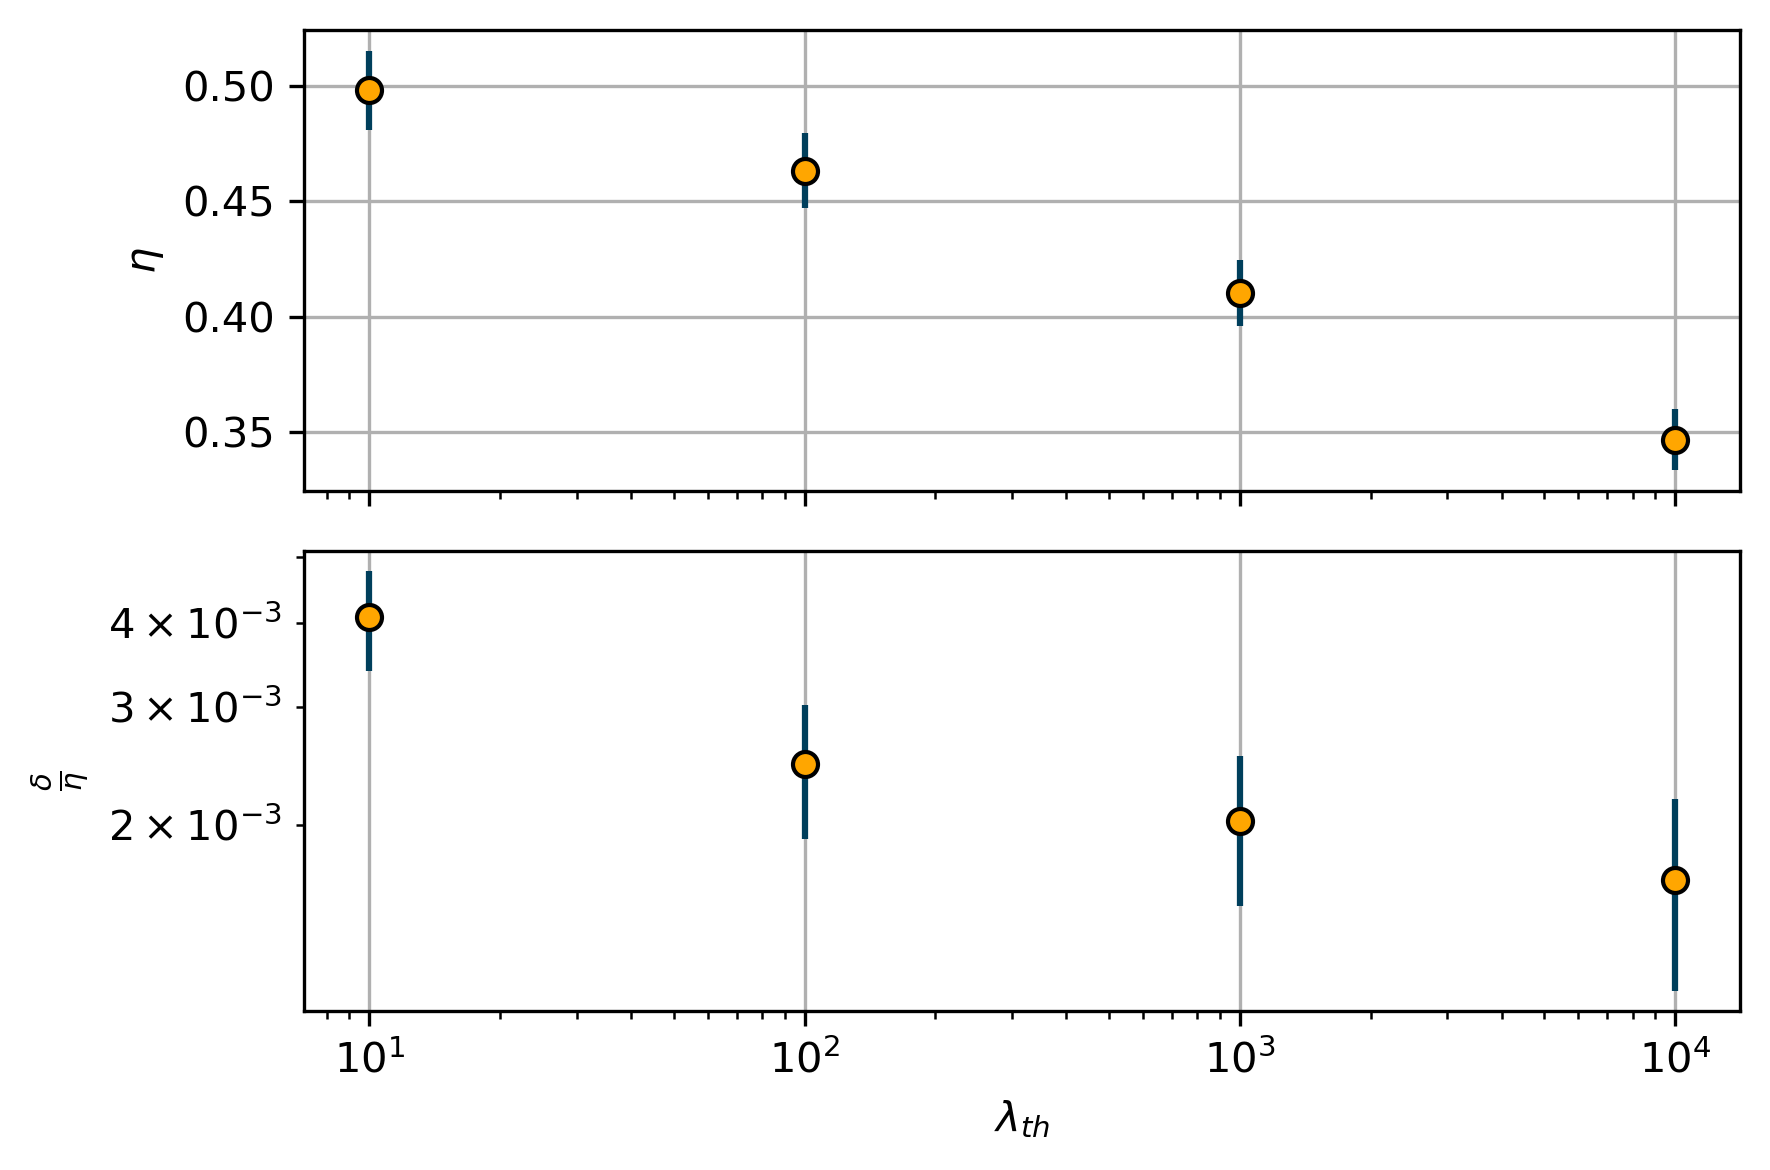

In [101]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.04506


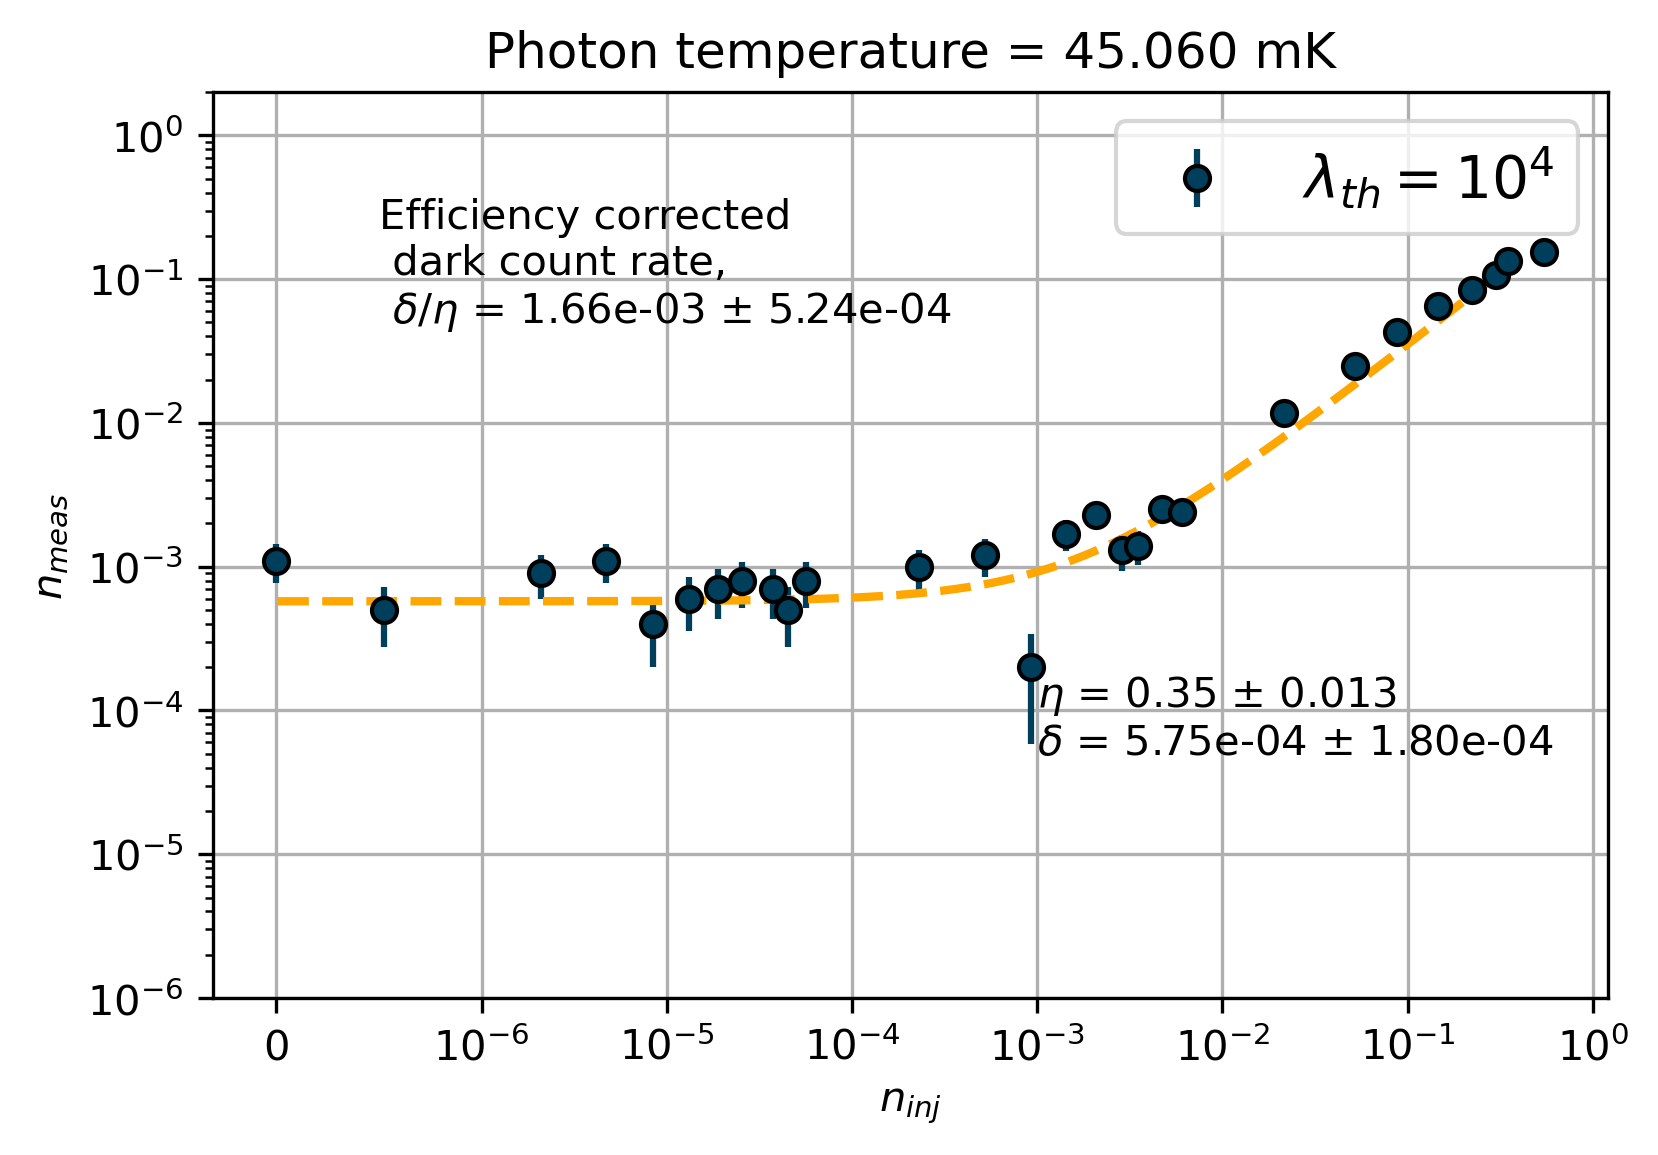

In [102]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='o', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[2.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 1

## Camp = 0.0, cav_len = 400ns

In [103]:
import json

filename = '..//data/stim_em_nobd_nodisc/00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 1

data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
inj_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//injected_photon//'
hist_path = '../data/thesis/00000_histogram_disc_clear.h5'

for amp in camp[:]:
    data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=hist_path, fstate_in=fock_state)
        p_n_counts.extend(p_n)        
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n1_camp_0.001_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.001_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00072342)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.001.h5
(10000, 1)
275
['00000_stim_em_n1_camp_0.002_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.002_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.002, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00144684)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.002.h5
(10000, 1)
257
['00000_stim_em_n1_camp_0.003_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.003_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.003, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00217026)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.003.h5
(10000, 1)
266
['00000_stim_em_n1_camp_0.004_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.004_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.004, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00289368)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.004.h5
(10000, 1)
275
['00000_stim_em_n1_camp_0.005_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.005_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.005, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00361709)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.005.h5
(10000, 1)
244
['00000_stim_em_n1_camp_0.006_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.006_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.006, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00434051)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.006.h5
(10000, 1)
238
['00000_stim_em_n1_camp_0.007_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.007_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.007, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00504764)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.007.h5
(10000, 1)
248
['00000_stim_em_n1_camp_0.008_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.008_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.008, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00611287)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.008.h5
(10000, 1)
235
['00000_stim_em_n1_camp_0.009_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.009_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.009, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0067126)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.009.h5
(10000, 1)
251
['00000_stim_em_n1_camp_0.01_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.01_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.01, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00752348)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.01.h5
(10000, 1)
253
['00000_stim_em_n1_camp_0.02_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.02_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.02, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.01518971)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.02.h5
(10000, 1)
270
['00000_stim_em_n1_camp_0.03_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.03_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.03, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.02281172)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.03.h5
(10000, 1)
274
['00000_stim_em_n1_camp_0.04_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.04_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.04, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0304455)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.04.h5
(10000, 1)
272
['00000_stim_em_n1_camp_0.05_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.05_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.05, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.03780074)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.05.h5
(10000, 1)
288
['00000_stim_em_n1_camp_0.06_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.06_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.06, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.04552206)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.06.h5
(10000, 1)
305
['00000_stim_em_n1_camp_0.07_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.07_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.07, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05360174)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.07.h5
(10000, 1)
295
['00000_stim_em_n1_camp_0.08_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.08_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.08, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05925771)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.08.h5
(10000, 1)
301
['00000_stim_em_n1_camp_0.09_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.09_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.09, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.06845682)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.09.h5
(10000, 1)
271
['00000_stim_em_n1_camp_0.1_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.1_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.1, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.07761038)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.1.h5
(10000, 1)
317
['00000_stim_em_n1_camp_0.2_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.2_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.2, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.14664004)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.2.h5
(10000, 1)
442
['00000_stim_em_n1_camp_0.3_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.3_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.3, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.22781655)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.3.h5
(10000, 1)
524
['00000_stim_em_n1_camp_0.4_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.4_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.4, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.29632022)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.4.h5
(10000, 1)
703
['00000_stim_em_n1_camp_0.5_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.5_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.5, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.38191889)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.5.h5
(10000, 1)
805
['00000_stim_em_n1_camp_0.6_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.6_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.6, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.47308384)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.6.h5
(10000, 1)
909
['00000_stim_em_n1_camp_0.7_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.7_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.7, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.54888121)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.7.h5
(10000, 1)
861
['00000_stim_em_n1_camp_0.8_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.8_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.8, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.59018374)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.8.h5
(10000, 1)
916
['00000_stim_em_n1_camp_0.9_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.9_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.9, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.73878927)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.9.h5
(10000, 1)
909
['00000_stim_em_n1_camp_0.0_len_10.h5']
..//data/stim_em_nobd_nodisc//n1//00000_stim_em_n1_camp_0.0_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.)]
..//data/stim_em_nobd_nodisc//n1//injected_photon//n1_camp_0.0.h5
(10000, 1)
246


## Photon counter line

In [104]:
data_path =  "../data/stim_em_nobd_nodisc/n1/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 5, 5)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 8)]= detect
    detected_th_err[np.round(alpha, 8)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n1_camp_0.0.h5
0.0
Total number of events collected: 10000, 145 events crossed \lambda 
n1_camp_0.001.h5
0.000723
Total number of events collected: 10000, 149 events crossed \lambda 
n1_camp_0.002.h5
0.001447
Total number of events collected: 10000, 146 events crossed \lambda 
n1_camp_0.003.h5
0.00217
Total number of events collected: 10000, 143 events crossed \lambda 
n1_camp_0.004.h5
0.002894
Total number of events collected: 10000, 161 events crossed \lambda 
n1_camp_0.005.h5
0.003617
Total number of events collected: 10000, 112 events crossed \lambda 
n1_camp_0.006.h5
0.004341
Total number of events collected: 10000, 132 events crossed \lambda 
n1_camp_0.007.h5
0.005048
Total number of events collected: 10000, 144 events crossed \lambda 
n1_camp_0.008.h5
0.006113
Total number of events collected: 10000, 131 events crossed \lambda 
n1_camp_0.009.h5
0.006713
Total number of events collected: 10000, 141 events crossed \lambda 
n1_camp_0.01.h5
0.007523
Total number of events collected:

In [5]:
len(n_exp), np.shape(y)

(28, (5, 28))

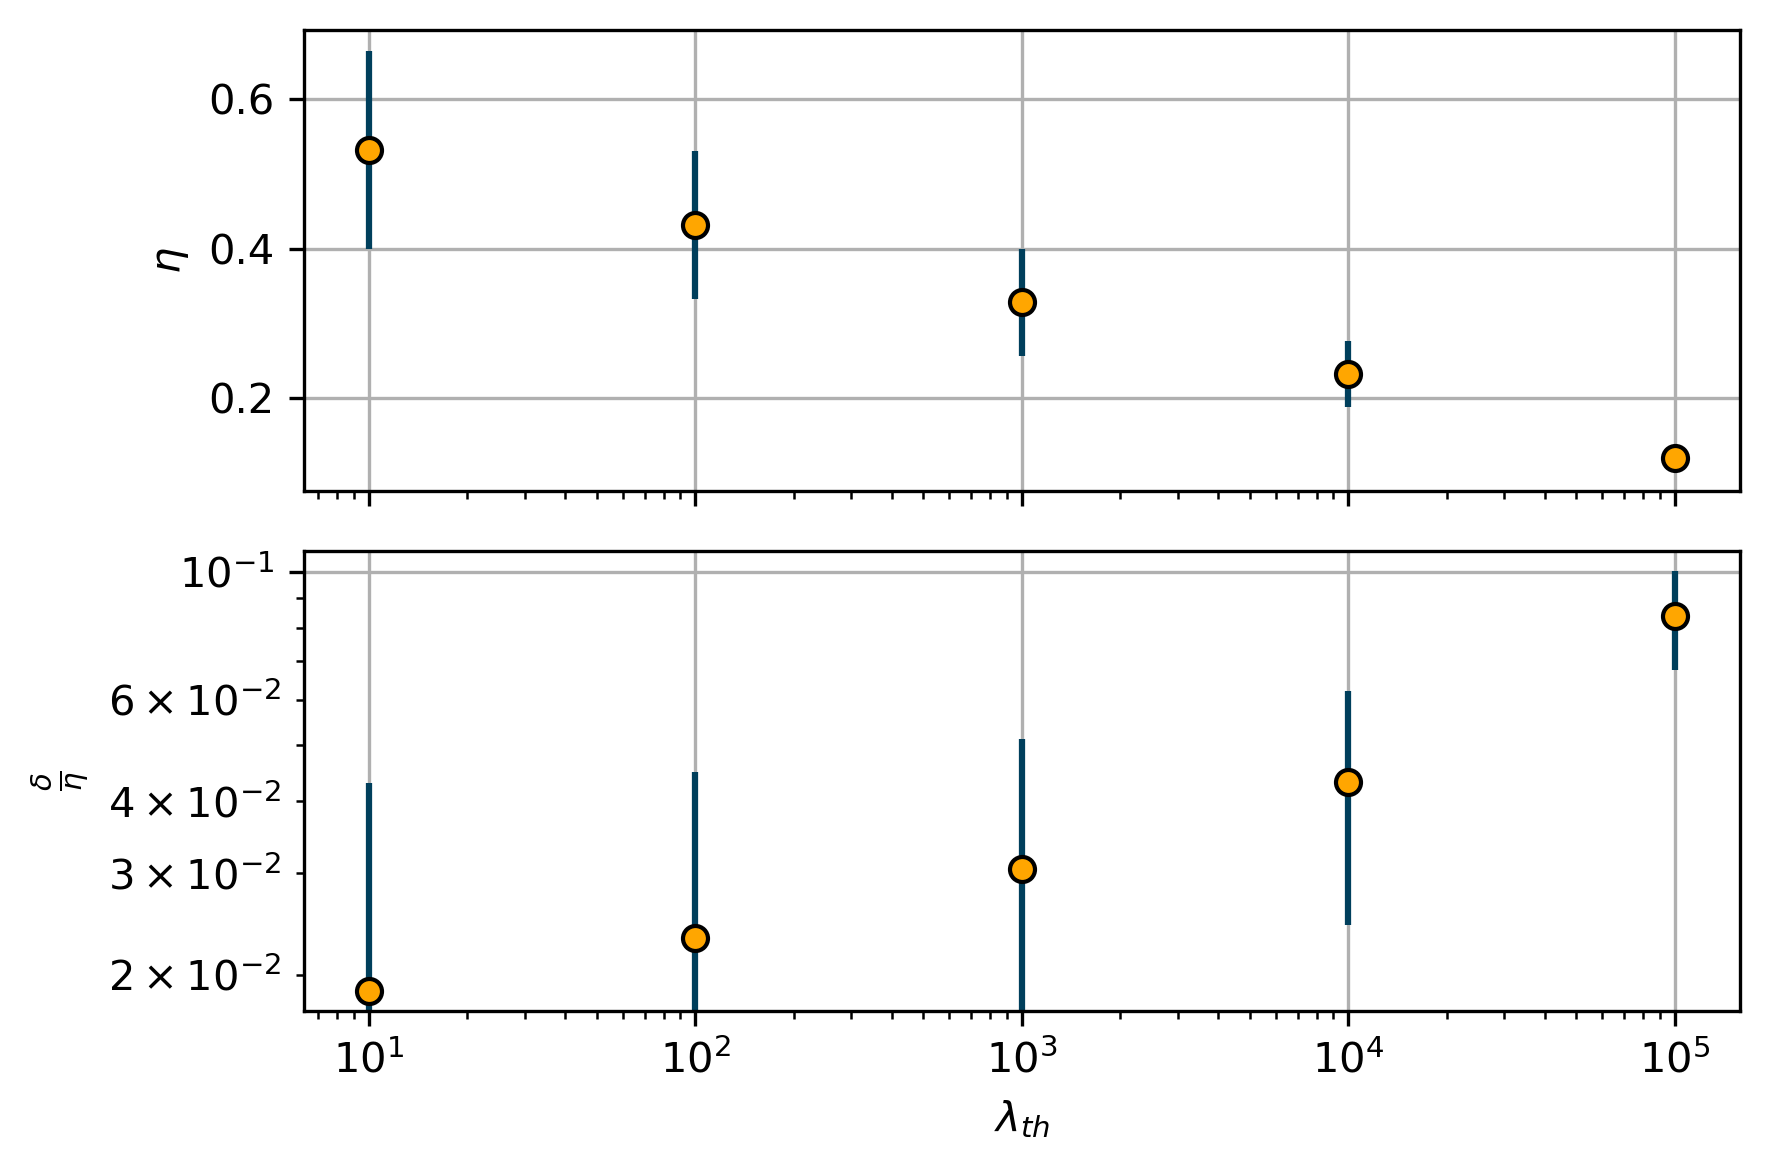

In [105]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.11637


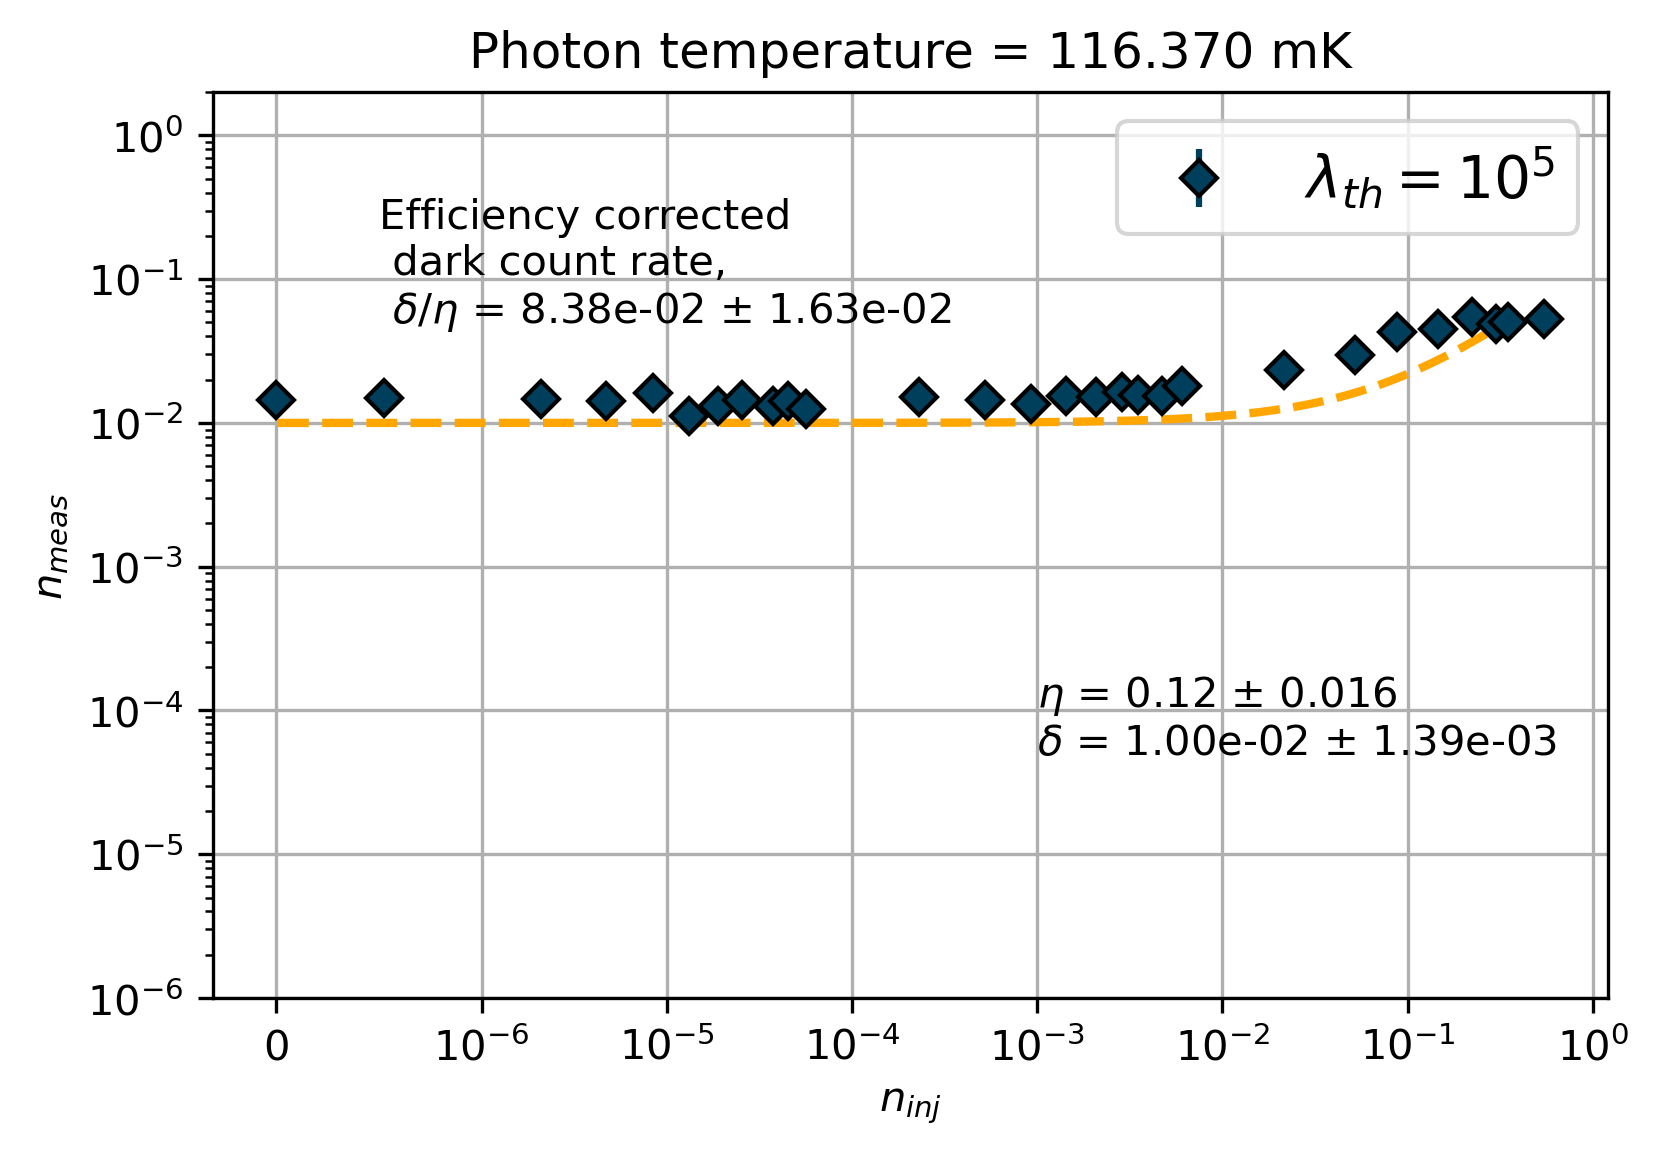

In [106]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 2

## Camp = 0.0, cav_len = 400 ns

In [107]:
import json

filename = '..//data/stim_em_nobd_nodisc/00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 2

data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
inj_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//injected_photon//'
hist_path = '../data/thesis/00000_histogram_disc_clear.h5'

for amp in camp[:]:
    data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=hist_path, fstate_in=fock_state)
        p_n_counts.extend(p_n)        
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n2_camp_0.001_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.001_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00072342)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.001.h5
(10000, 1)
89
['00000_stim_em_n2_camp_0.002_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.002_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.002, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00144684)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.002.h5
(10000, 1)
89
['00000_stim_em_n2_camp_0.003_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.003_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.003, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00217026)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.003.h5
(10000, 1)
109
['00000_stim_em_n2_camp_0.004_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.004_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.004, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00289368)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.004.h5
(10000, 1)
78
['00000_stim_em_n2_camp_0.005_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.005_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.005, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00361709)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.005.h5
(10000, 1)
91
['00000_stim_em_n2_camp_0.006_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.006_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.006, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00434051)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.006.h5
(10000, 1)
100
['00000_stim_em_n2_camp_0.007_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.007_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.007, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00504764)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.007.h5
(10000, 1)
103
['00000_stim_em_n2_camp_0.008_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.008_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.008, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00611287)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.008.h5
(10000, 1)
80
['00000_stim_em_n2_camp_0.009_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.009_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.009, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0067126)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.009.h5
(10000, 1)
114
['00000_stim_em_n2_camp_0.01_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.01_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.01, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00752348)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.01.h5
(10000, 1)
88
['00000_stim_em_n2_camp_0.02_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.02_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.02, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.01518971)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.02.h5
(10000, 1)
85
['00000_stim_em_n2_camp_0.03_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.03_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.03, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.02281172)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.03.h5
(10000, 1)
103
['00000_stim_em_n2_camp_0.04_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.04_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.04, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0304455)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.04.h5
(10000, 1)
100
['00000_stim_em_n2_camp_0.05_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.05_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.05, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.03780074)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.05.h5
(10000, 1)
108
['00000_stim_em_n2_camp_0.06_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.06_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.06, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.04552206)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.06.h5
(10000, 1)
98
['00000_stim_em_n2_camp_0.07_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.07_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.07, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05360174)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.07.h5
(10000, 1)
95
['00000_stim_em_n2_camp_0.08_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.08_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.08, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05925771)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.08.h5
(10000, 1)
108
['00000_stim_em_n2_camp_0.09_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.09_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.09, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.06845682)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.09.h5
(10000, 1)
125
['00000_stim_em_n2_camp_0.1_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.1_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.1, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.07761038)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.1.h5
(10000, 1)
103
['00000_stim_em_n2_camp_0.2_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.2_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.2, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.14664004)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.2.h5
(10000, 1)
186
['00000_stim_em_n2_camp_0.3_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.3_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.3, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.22781655)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.3.h5
(10000, 1)
294
['00000_stim_em_n2_camp_0.4_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.4_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.4, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.29632022)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.4.h5
(10000, 1)
425
['00000_stim_em_n2_camp_0.5_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.5_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.5, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.38191889)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.5.h5
(10000, 1)
504
['00000_stim_em_n2_camp_0.6_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.6_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.6, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.47308384)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.6.h5
(10000, 1)
611
['00000_stim_em_n2_camp_0.7_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.7_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.7, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.54888121)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.7.h5
(10000, 1)
649
['00000_stim_em_n2_camp_0.8_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.8_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.8, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.59018374)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.8.h5
(10000, 1)
650
['00000_stim_em_n2_camp_0.9_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.9_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.9, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.73878927)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.9.h5
(10000, 1)
588
['00000_stim_em_n2_camp_0.0_len_10.h5']
..//data/stim_em_nobd_nodisc//n2//00000_stim_em_n2_camp_0.0_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.)]
..//data/stim_em_nobd_nodisc//n2//injected_photon//n2_camp_0.0.h5
(10000, 1)
84


## Photon counter fit

In [108]:
data_path =  "../data/stim_em_nobd_nodisc//n2/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 8)]= detect
    detected_th_err[np.round(alpha, 8)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n2_camp_0.0.h5
0.0
Total number of events collected: 10000, 84 events crossed \lambda 
n2_camp_0.001.h5
0.000723
Total number of events collected: 10000, 89 events crossed \lambda 
n2_camp_0.002.h5
0.001447
Total number of events collected: 10000, 89 events crossed \lambda 
n2_camp_0.003.h5
0.00217
Total number of events collected: 10000, 109 events crossed \lambda 
n2_camp_0.004.h5
0.002894
Total number of events collected: 10000, 78 events crossed \lambda 
n2_camp_0.005.h5
0.003617
Total number of events collected: 10000, 91 events crossed \lambda 
n2_camp_0.006.h5
0.004341
Total number of events collected: 10000, 100 events crossed \lambda 
n2_camp_0.007.h5
0.005048
Total number of events collected: 10000, 103 events crossed \lambda 
n2_camp_0.008.h5
0.006113
Total number of events collected: 10000, 80 events crossed \lambda 
n2_camp_0.009.h5
0.006713
Total number of events collected: 10000, 114 events crossed \lambda 
n2_camp_0.01.h5
0.007523
Total number of events collected: 10000

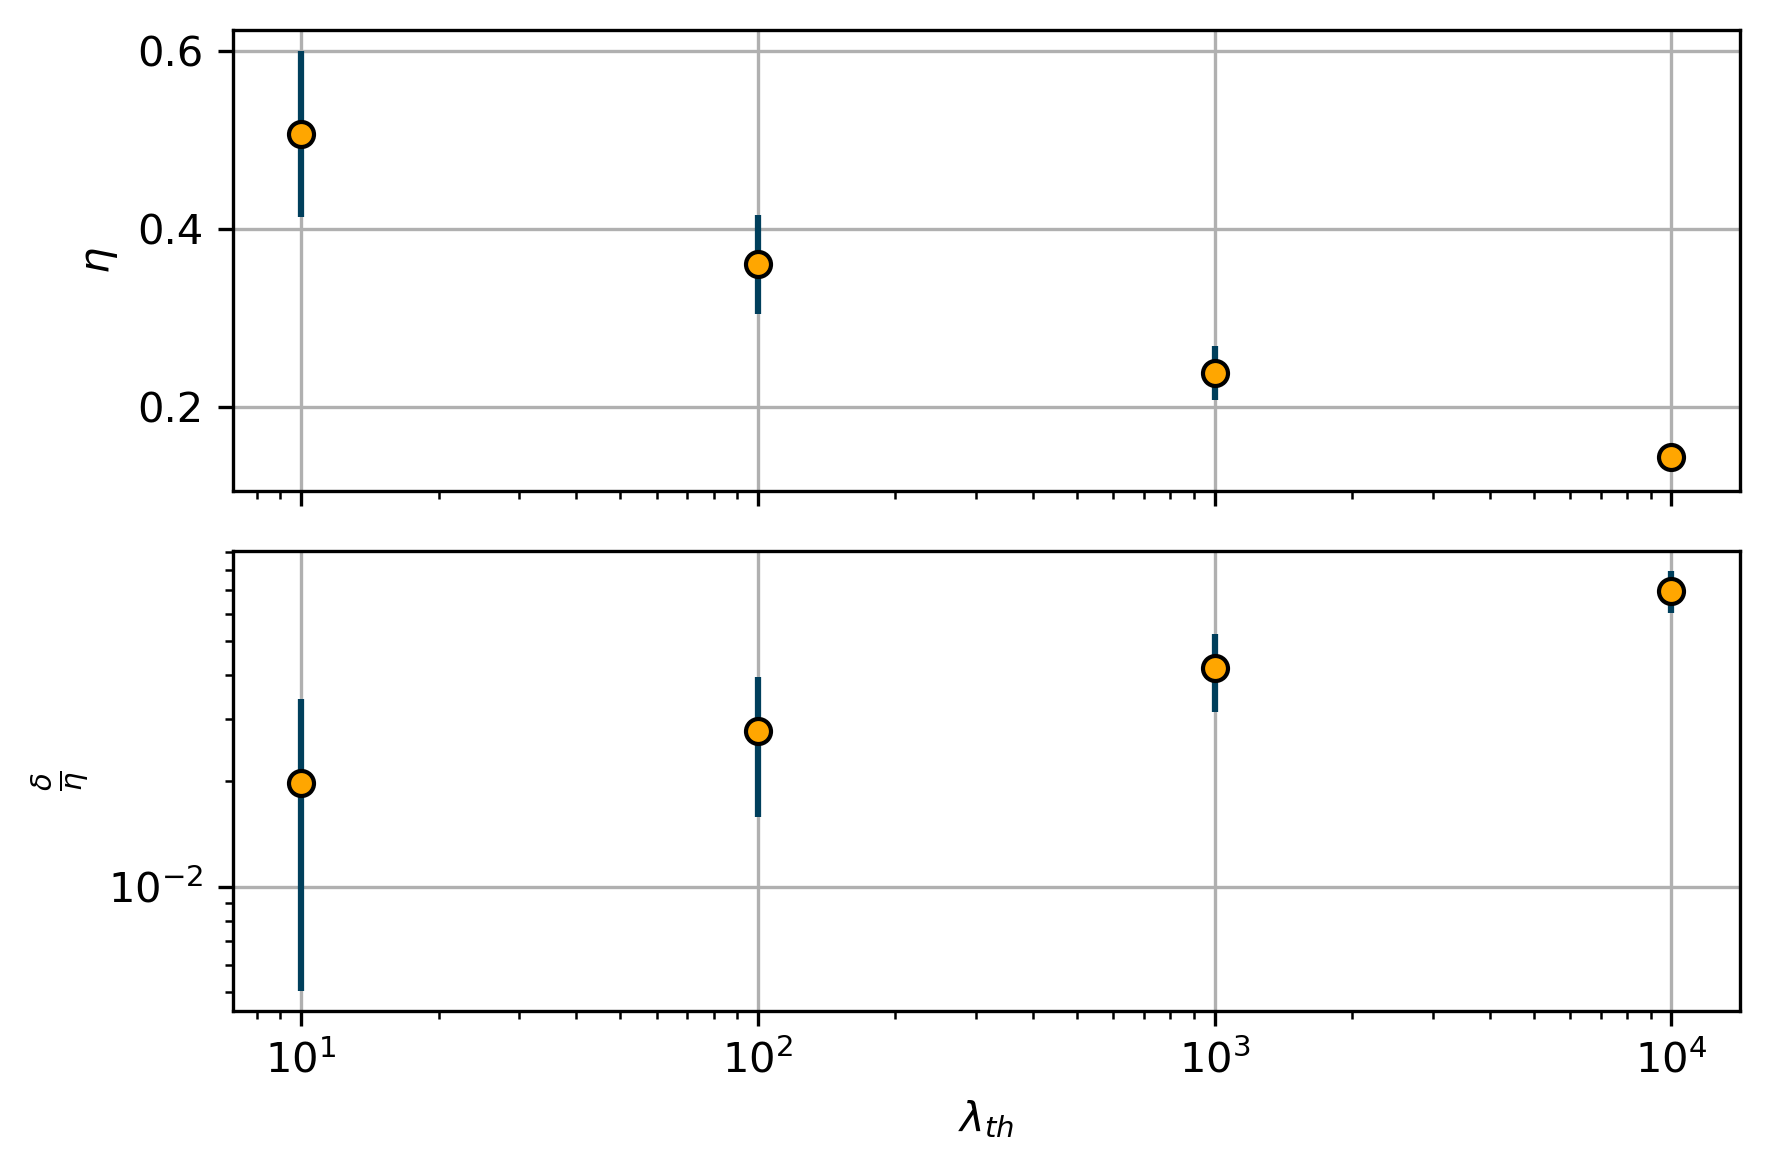

In [109]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.10825


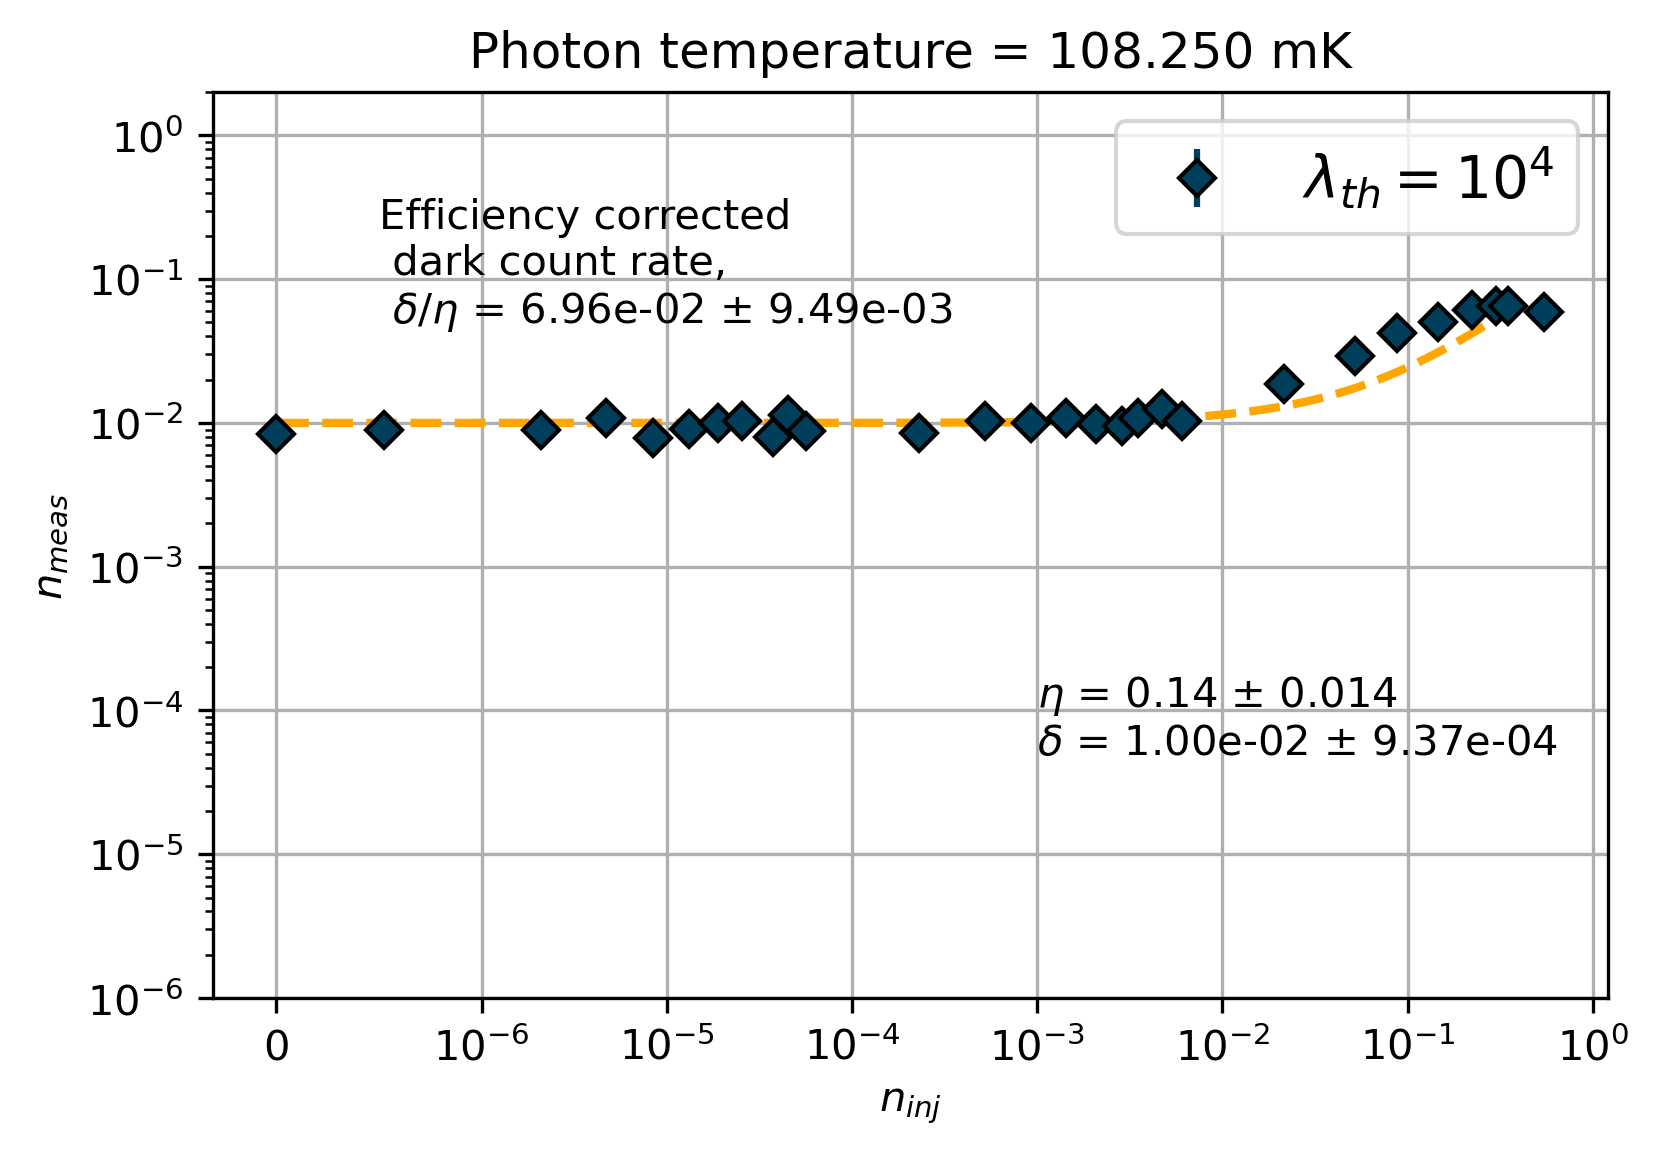

In [110]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

# Stim Em with repeated pi pulses at |n> = 3

## Camp = 0.05, cav_len = 400 ns

In [111]:
import json

filename = '..//data/stim_em_nobd_nodisc/00000_analysis_params.json' 
# Opening JSON file
f = open(filename)
 
# returns JSON object as
# a dictionary
data = json.load(f)
    
qubit_params = data['qubit_params']
cavity_params = data['cavity_params']
readout_params = data['readout_params']

camp = list(np.round(np.arange(0.001, 0.0095, 0.001).tolist(), 6))
camp.extend(np.round(np.arange(0.01, 0.095, 0.01).tolist(), 6))
camp.extend(np.round(np.arange(0.1, 0.95, 0.1).tolist(), 6))
camp.append(0.0)

fock_state = 3

data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
inj_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//injected_photon//'
hist_path = '../data/thesis/00000_histogram_disc_clear.h5'

for amp in camp[:]:
    data_path = '..//data/stim_em_nobd_nodisc//n'+ str(fock_state)+'//'
    filelist = [f for f in os.listdir(data_path) if str(amp)+'_' in f ]
    print(filelist)
    p_m_counts = []
    p_n_counts = []
    alphas = []
    for ii, i in enumerate(filelist):

        filename = data_path+filelist[ii]
        print(filename)
        obj = hmm_analysis_stimem(qubit_params=qubit_params, cavity_params=cavity_params, readout_params=readout_params)
        alpha, amp, p_n = obj.stateprep(data_filename=filename, at_end=True, hist_file=hist_path, fstate_in=fock_state)
        p_n_counts.extend(p_n)        
        alphas.append(alpha)

    print(alphas)
    filename = inj_path + "n" + str(fock_state) +"_camp_" + str(amp)+".h5"
    print(filename)

    with File(filename, 'w') as f:
        f.create_dataset("p_n_counts", data=p_n_counts)
        f.create_dataset("alpha", data = alpha)
        f.close()

    df = pd.DataFrame({'p_n': p_n_counts})

    print(np.shape(df))
    th1 = 1e2
    th2 = 1e4

    count_n = df['p_n'][df['p_n']>th2].count()
    print(count_n)

['00000_stim_em_n3_camp_0.001_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.001_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.001, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00072342)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.001.h5
(10000, 1)
23
['00000_stim_em_n3_camp_0.002_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.002_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.002, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00144684)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.002.h5
(10000, 1)
28
['00000_stim_em_n3_camp_0.003_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.003_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.003, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00217026)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.003.h5
(10000, 1)
24
['00000_stim_em_n3_camp_0.004_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.004_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.004, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00289368)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.004.h5
(10000, 1)
25
['00000_stim_em_n3_camp_0.005_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.005_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.005, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00361709)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.005.h5
(10000, 1)
27
['00000_stim_em_n3_camp_0.006_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.006_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.006, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00434051)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.006.h5
(10000, 1)
28
['00000_stim_em_n3_camp_0.007_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.007_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.007, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00504764)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.007.h5
(10000, 1)
29
['00000_stim_em_n3_camp_0.008_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.008_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.008, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00611287)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.008.h5
(10000, 1)
34
['00000_stim_em_n3_camp_0.009_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.009_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.009, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0067126)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.009.h5
(10000, 1)
22
['00000_stim_em_n3_camp_0.01_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.01_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.01, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.00752348)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.01.h5
(10000, 1)
28
['00000_stim_em_n3_camp_0.02_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.02_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.02, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.01518971)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.02.h5
(10000, 1)
15
['00000_stim_em_n3_camp_0.03_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.03_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.03, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.02281172)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.03.h5
(10000, 1)
23
['00000_stim_em_n3_camp_0.04_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.04_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.04, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.0304455)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.04.h5
(10000, 1)
23
['00000_stim_em_n3_camp_0.05_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.05_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.05, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.03780074)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.05.h5
(10000, 1)
30
['00000_stim_em_n3_camp_0.06_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.06_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.06, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.04552206)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.06.h5
(10000, 1)
32
['00000_stim_em_n3_camp_0.07_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.07_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.07, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05360174)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.07.h5
(10000, 1)
30
['00000_stim_em_n3_camp_0.08_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.08_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.08, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.05925771)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.08.h5
(10000, 1)
31
['00000_stim_em_n3_camp_0.09_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.09_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.09, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.06845682)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.09.h5
(10000, 1)
23
['00000_stim_em_n3_camp_0.1_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.1_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.1, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.07761038)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.1.h5
(10000, 1)
24
['00000_stim_em_n3_camp_0.2_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.2_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.2, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.14664004)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.2.h5
(10000, 1)
64
['00000_stim_em_n3_camp_0.3_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.3_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.3, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.22781655)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.3.h5
(10000, 1)
107
['00000_stim_em_n3_camp_0.4_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.4_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.4, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.29632022)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.4.h5
(10000, 1)
149
['00000_stim_em_n3_camp_0.5_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.5_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.5, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.38191889)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.5.h5
(10000, 1)
161
['00000_stim_em_n3_camp_0.6_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.6_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.6, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.47308384)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.6.h5
(10000, 1)
153
['00000_stim_em_n3_camp_0.7_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.7_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.7, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.54888121)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.7.h5
(10000, 1)
148
['00000_stim_em_n3_camp_0.8_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.8_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.8, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.59018374)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.8.h5
(10000, 1)
144
['00000_stim_em_n3_camp_0.9_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.9_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.9, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.73878927)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.9.h5
(10000, 1)
93
['00000_stim_em_n3_camp_0.0_len_10.h5']
..//data/stim_em_nobd_nodisc//n3//00000_stim_em_n3_camp_0.0_len_10.h5
# of π at m= 0, at n = 30
Coherent drive: amp = 0.0, length = 10 ns


<ipython-input-68-fc9dc1aaa2b8>:119: RuntimeWarning: invalid value encountered in true_divide
  probs_counts = probs_counts/sum(probs_counts)


[array(0.)]
..//data/stim_em_nobd_nodisc//n3//injected_photon//n3_camp_0.0.h5
(10000, 1)
20


## Photon counter fit

In [112]:
data_path =  "../data/stim_em_nobd_nodisc/n3/injected_photon/"
filenames_like = os.listdir(data_path)

th_n = np.logspace(1, 4, 4)
detected_th = {}
detected_th_err = {}
alphas = []
for jj, filename in enumerate(filenames_like):
    print(filename)
    filename = data_path + filename
    with File(filename,'r') as a:
        p_n_counts = np.array(a['p_n_counts'], dtype=float)
        alpha = np.array(a['alpha'])
        print(np.round(alpha, 6))
        a.close()
    alphas.append(np.round(alpha, 6))
    detect = []
    detect_err = []
    detect_err_bi = []
    for th in th_n:
        df = pd.DataFrame(p_n_counts)
        count_n = df[df>th].count()
        t = count_n/len(p_n_counts)
        detect.append(t)
        detect_err.append(np.sqrt(count_n)/len(p_n_counts))
    print(r"Total number of events collected: %d, %d events crossed \lambda "%(len(p_n_counts), count_n))
    detected_th[np.round(alpha, 8)]= detect
    detected_th_err[np.round(alpha, 8)] = detect_err

"""Sorts the columns according to injected photon number"""
y = pd.DataFrame(detected_th).sort_index(axis=1)
yerr = pd.DataFrame(detected_th_err).sort_index(axis=1)
n_exp = np.sort(np.array(alphas)**2)

n3_camp_0.0.h5
0.0
Total number of events collected: 10000, 20 events crossed \lambda 
n3_camp_0.001.h5
0.000723
Total number of events collected: 10000, 23 events crossed \lambda 
n3_camp_0.002.h5
0.001447
Total number of events collected: 10000, 28 events crossed \lambda 
n3_camp_0.003.h5
0.00217
Total number of events collected: 10000, 24 events crossed \lambda 
n3_camp_0.004.h5
0.002894
Total number of events collected: 10000, 25 events crossed \lambda 
n3_camp_0.005.h5
0.003617
Total number of events collected: 10000, 27 events crossed \lambda 
n3_camp_0.006.h5
0.004341
Total number of events collected: 10000, 28 events crossed \lambda 
n3_camp_0.007.h5
0.005048
Total number of events collected: 10000, 29 events crossed \lambda 
n3_camp_0.008.h5
0.006113
Total number of events collected: 10000, 34 events crossed \lambda 
n3_camp_0.009.h5
0.006713
Total number of events collected: 10000, 22 events crossed \lambda 
n3_camp_0.01.h5
0.007523
Total number of events collected: 10000, 28

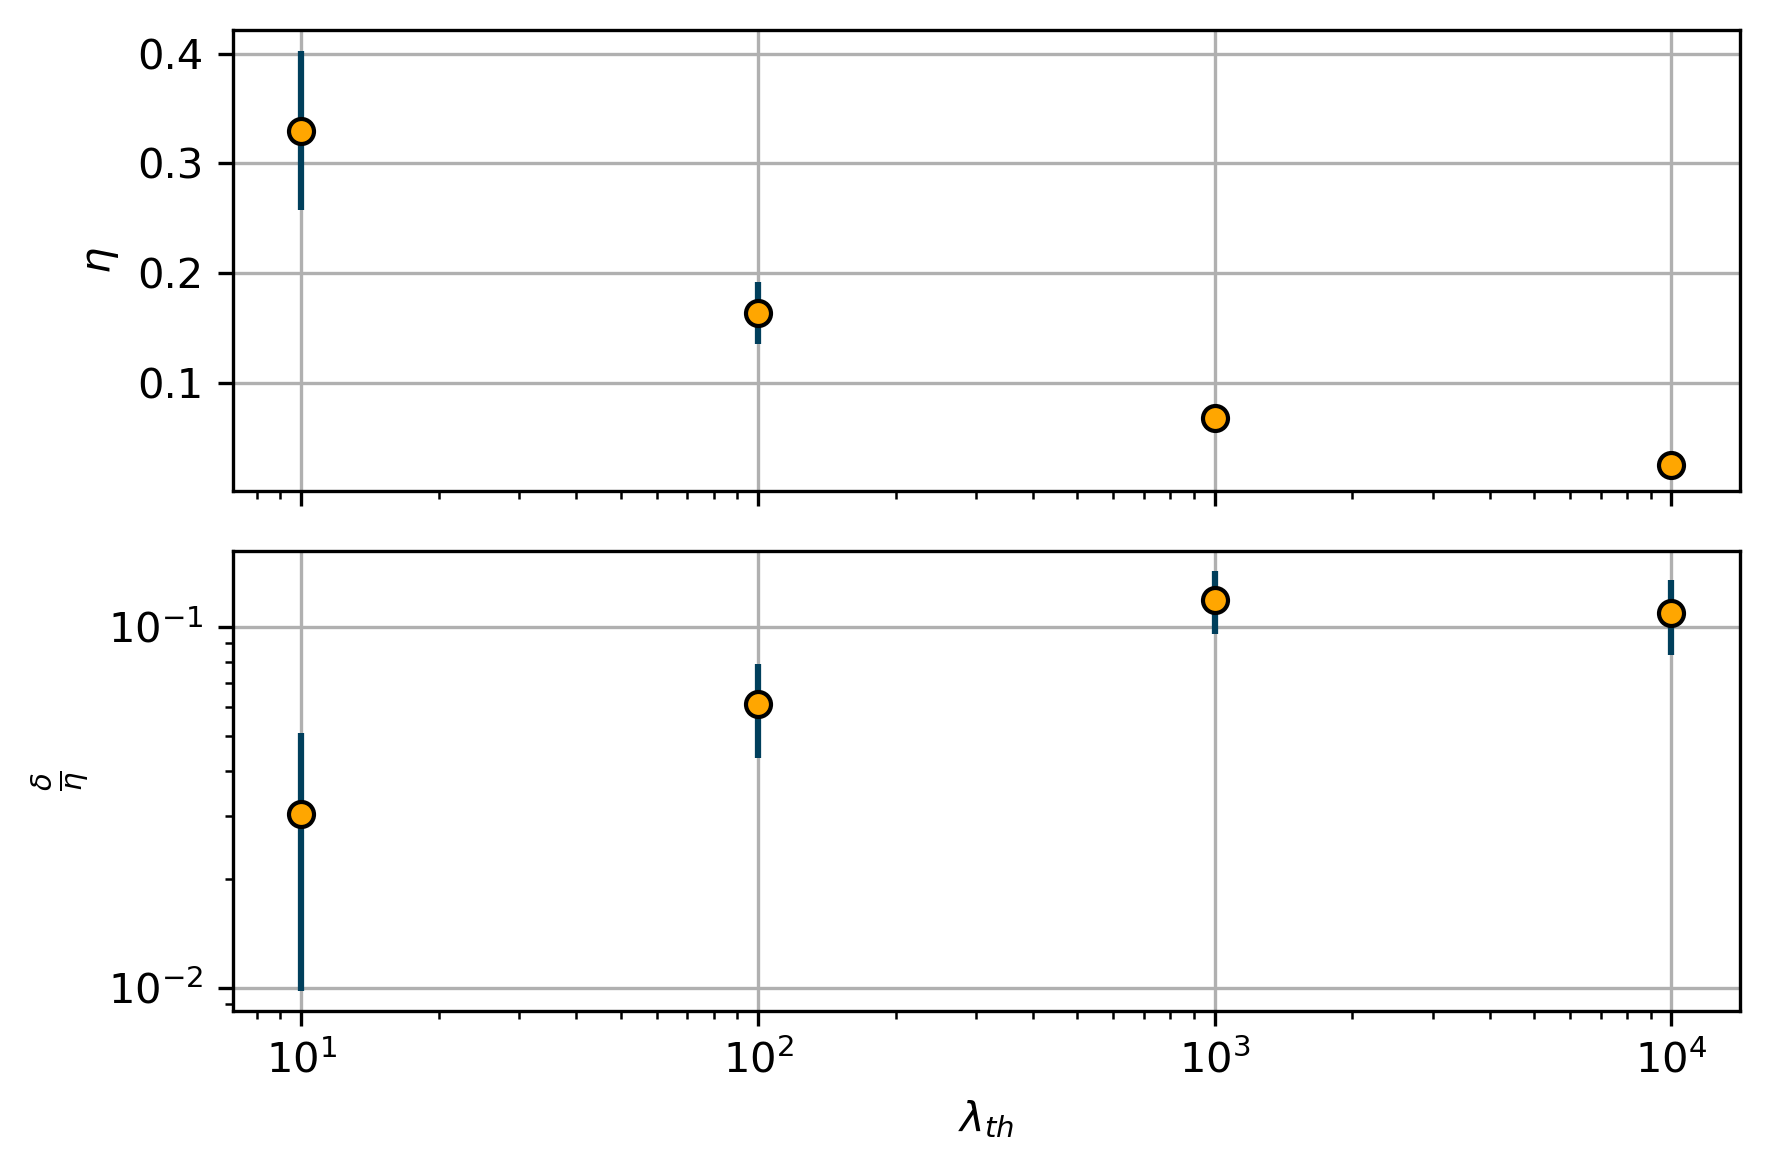

In [113]:
def photon_counter_line0(x, eff, err):
    return eff*(np.array(x)) + err

det_eff = []
det_darkcount = []
eff_corr_darkcount = []

for ii in range(len(th_n)):
    popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[ii], dtype=float), sigma=np.array(yerr.iloc[ii], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
    perr = np.sqrt(np.diag(pcov))
    det_eff.append([popt[0], perr[0]])
    det_darkcount.append([popt[1], perr[1]])
    err = np.sqrt((perr[1]/(popt[0]))**2 + (perr[0]*(popt[1]/(popt[0]**2)))**2)
    eff_corr_darkcount.append([popt[1]/(popt[0]), err])
    
    
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_n, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_n, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, dpi=300, sharex=True)
ax1.errorbar(x= th_m, y= pd.DataFrame(det_eff)[0], yerr= pd.DataFrame(det_eff)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax1.set_ylabel(r'$\eta$')
ax1.grid(minorticks_on)
ax2.errorbar(x= th_m, y= pd.DataFrame(eff_corr_darkcount)[0], yerr= pd.DataFrame(eff_corr_darkcount)[1],
             fmt='o',  capthick=4, markerfacecolor='#ffa600', markeredgecolor='k', ecolor='#003f5c')
ax2.set_ylabel(r'$\frac{\delta}{\eta}$')
ax2.set_xlabel(r'$\lambda_{th}$')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(minorticks_on)
plt.tight_layout()
plt.show()

0.13021


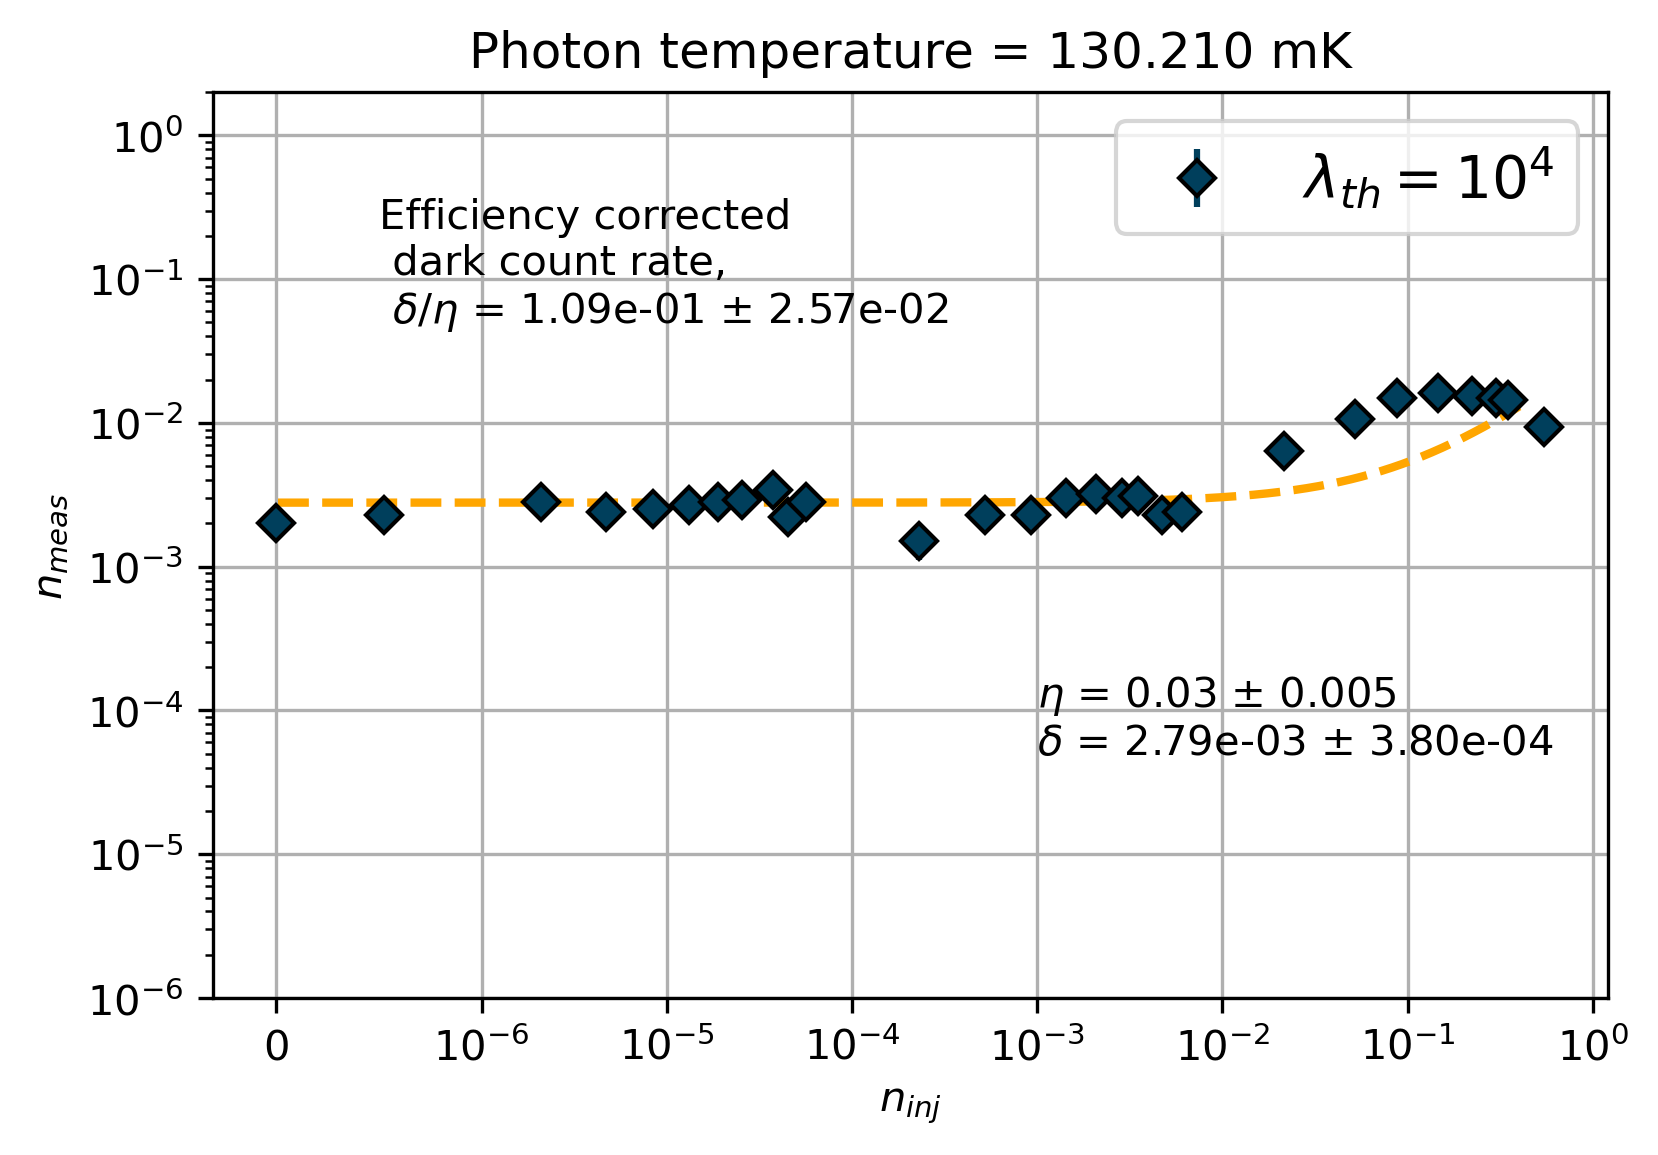

In [114]:
#003f5c
#58508d
#bc5090
#ff6361
#ffa600
m = 1
plt.figure(dpi=300)
plt.errorbar(n_exp, y= y.iloc[-m], yerr= yerr.iloc[-m], fmt='D', capthick=4, 
            markerfacecolor='#003f5c', markeredgecolor='k', ecolor='#003f5c',
                 label=r'$\lambda_{th} =  10^{%.f}$'%(np.log10(th_n[-m])))

popt, pcov = curve_fit(f=photon_counter_line0, xdata=n_exp, ydata=np.array(y.iloc[-m], dtype=float), sigma=np.array(yerr.iloc[-m], dtype=float), 
                           bounds = ([0.0, 1e-5],[1.0, 1e-2]))
perr = np.sqrt(np.diag(pcov))
delta_eta  = popt[1]/popt[0]
delta_eta_err = delta_eta*(np.sqrt((perr[0]/popt[0])**2 + (perr[1]/popt[1])**2))
###########
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = np.round(hbar*w/(k*np.log(1/delta_eta)), 5)
print(T)
###########
x = np.linspace(1e-8, 4e-1, 100001)
h = photon_counter_line0(x, *popt)
plt.plot(x, h, linewidth=2, linestyle='--', color='#ffa600')
plt.ylabel(r'$n_{meas}$')
plt.xlabel(r'$n_{inj}$')
plt.xscale('symlog', linthresh=1e-6)
# plt.yscale('symlog', linthreshy=1e-5)
plt.yscale('log')
plt.ylim(1e-6, 2e0)
plt.text(1e-3, 5e-5, '$\eta$ = {:^.2f} $\pm$ {:^.3f} \n$\delta$ = {:^.2e} $\pm$ {:^.2e}'.format(popt[0], perr[0], popt[1], perr[1]))
plt.text(5e-7, 5e-2, 'Efficiency corrected \n dark count rate,\
        \n $\delta$/$\eta$ = {:<.2e} $\pm$ {:<.2e}'.format(delta_eta, delta_eta_err))
plt.title('Photon temperature = {:.3f} mK'.format(T*1000))
plt.legend(fontsize=14, loc='best') 
plt.grid(minorticks_on)
# plt.savefig('2021-05-24-PhotonCounting.png', dpi=300)
plt.show()

In [ ]:
w = 2*np.pi*6.011*1e9

from scipy.constants import hbar, k

T = hbar*w/(k*np.log(1/3.28e-4))
print(T)